Please fill out:
* Student name: Tamjid Ahsan
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# INTRODUCTION

<img src="./assets/image_1.png"
     alt="Map!"
     style="float: center; margin-center: 2px;">
     
Source: image generated by author using tableau public.

## Overview

## Business problem

King County Residents that want to renovate their home to increase its resale value, but don't know what factors are important for determining a home's value. While focusing on features they can renovate, you can still discuss key factors of a home's price that are outside of their control. 

## Recommendation

# The imports

## Packages

In [1]:
# operational packeges
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns',0)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import statistics as stat
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

# styling packages
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks='True', grid='False')
## to reset to default theme
# jtplot.reset() 

## Functions used

### Exploration

In [2]:
def check_NaN(df):
    """
    Checks for NaN in the pandas DataFrame and spits a DataFrame of report.
    Uses df.isnull() method.
    
    Parameters:
    ===========
    df = pandas.DataFrame
    """
    null_checking = []
    for column in df.columns:
        not_null = df[column].isnull().value_counts()[0]
        try:
            is_null = df[column].isnull().value_counts()[1]
        except:
            is_null = 0
        temp_dict = {'name': column, 'is_null': is_null, 'not_null': not_null}
        null_checking.append(temp_dict)
    df_ = pd.DataFrame(null_checking)
    return df_

In [3]:
def check_duplicates(df):
    """
    Checks for duplicates in the pandas DataFrame and splits a Dataframe of report.
    
    Parameters:
    ===========
    df = pandas.DataFrame
    """
    dup_checking = []
    for column in df.columns:
        not_duplicated = df[column].duplicated().value_counts()[0]
        try:
            duplicated = df[column].duplicated().value_counts()[1]
        except:
            duplicated = 0
        temp_dict = {
            'name': column,
            'duplicated': duplicated,
            'not_duplicated': not_duplicated
        }
        dup_checking.append(temp_dict)
    df_ = pd.DataFrame(dup_checking)
    return df_

In [4]:
def correlation_top_bottom(df):
    """
    Input a Pandas correlation matrix DataFrame (df.corr()) to get top 10 positive and negetively correlated features.
    
    Parameters:
    ===========
    df = pandas.core.frame.DataFrame; use df.corr().
    """
    corr_df_matrix_ = df.unstack().reset_index()
    corr_df_matrix_.columns = ["feature_0", 'feature_1', 'correlation']
    corr_df_matrix_['keep'] = corr_df_matrix_.apply(
        lambda x: False if x['feature_0'] == x['feature_1'] else True, axis=1)
    corr_df_matrix_['feature_combo'] = corr_df_matrix_.apply(
        lambda x: ' and '.join(set(x[['feature_0', 'feature_1']])), axis=1)
    corr_featurs = corr_df_matrix_[corr_df_matrix_.keep][[
        'feature_combo', 'correlation'
    ]].drop_duplicates().sort_values(by='correlation', ascending=False)
    print(
        f'Positive correlations:\n{corr_featurs.head(10).reset_index()}\n\n{"-"*70}\nNegative correlations:\n{corr_featurs.sort_values(by="correlation").head(10).reset_index()}'
    )

In [5]:
# Number formatter
def format_number(data_value, index):
    """
    Formats values to thousands, millions and billions.
    Used for modifying chart axes.
    +++ formatting helper function +++
    """
    if data_value >= 1_000_000_000:
        formatter = '${:1.1f}B'.format(data_value * 0.000_000_001)
    elif data_value >= 1_000_000:
        formatter = '${:1.0f}M'.format(data_value * 0.000_001)
    else:
        formatter = '${:1.0f}K'.format(data_value * 0.001)
    return formatter

In [6]:
# SG Function
def kde_boxplot(x):
    import scipy.stats as stats
    # Create two vertical subplots sharing 15% and 85% of plot space
    # sharex allows sharing of axes i.e. building multiple plots on same axes
    fig, (ax, ax2) = plt.subplots(nrows=2,
                                  sharex=True,
                                  gridspec_kw={"height_ratios": (.15, .85)},
                                  figsize=(10, 8))
    sns.histplot(x,
                 bins=20,
                 alpha=.5,
                 color='silver',
                 stat="density",
                 fill=True,
                 label='hist',
                 palette="pastel",
                 element='step',
                 ax=ax2)
    sns.kdeplot(x, color='gold', label='kde', palette="pastel", ax=ax2)
    ax2.xaxis.set_major_formatter(format_number)
    ax.set_title(f'{x.name} histogram and kde')

    ax2.set_title('Density Estimations')
    sns.boxplot(x=x, ax=ax, color='gold')
    ax.set_title('Box and Whiskers Plot')
    plt.legend()

In [7]:
def feature_prob_details(x, alpha=.05):
    """
    Displays:
    =========
    Plots boxplot, density plot, cdf and probability plot with fitting of given data.
    Decison based on both:
    Shapiro-Wilk Test and Kolmogorov-Smirnov test for goodness of fit at 95% confidence interval.
    
    Parameters:
    ===========
    x = array OR DataFrame Series Object; target data
    alpha = float; default: .05
    
    Note:
    =====
    For Kolmogorov-Smirnov it uses two sided test. To change this modify source code.
    """
    plt.close('all')
    fig = plt.figure(figsize=(14, 6))

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (0, 2))
    ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
    ax4 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
    # ax1
    sns.boxplot(x=x, ax=ax1,
                color='gold')  #.xaxis.set_major_formatter(format_number)
    ax1.set_title('Box and Whiskers Plot')
    # ax2
    sns.kdeplot(x,
                color='gold',
                label='kde',
                palette="pastel",
                cumulative=True,
                ax=ax2)
    ax2.set_title('CDF')
    # ax3
    sns.histplot(x,
                 bins=20,
                 alpha=.5,
                 color='silver',
                 stat="density",
                 fill=True,
                 label='hist',
                 palette="pastel",
                 element='step',
                 ax=ax3).xaxis.set_major_formatter(format_number)
    sns.kdeplot(x, color='gold', label='kde', palette="pastel", ax=ax3)
    ax3.set_title('Density Estimation')
    ax3.legend()
    # ax4
    sm.graphics.qqplot(x,
                       fit=True,
                       line='r',
                       marker='h',
                       markerfacecolor='silver',
                       alpha=0.5,
                       ax=ax4)
    sm.qqline(line='45', fmt='g--', lw=1, alpha=.8, ax=ax4)
    ax4.set_title('Probability Plot')
    plt.suptitle(t=f'Probability details of "{x.name}" feature',
                 size=20,
                 weight=14)
    plt.tight_layout()
    plt.show()
    from scipy.stats import shapiro
    from scipy.stats import kstest
    t_stat, p_val = shapiro(x)
    t_stat1, p_val1 = kstest(x, stats.norm.cdf)
    alpha = alpha
    if (p_val or p_val1) < alpha:
        print(
            f'Distribution is NOT NORMAL based on Shapiro-Wilk Test and Kolmogorov-Smirnov test for goodness of fit at {(1-alpha)*100}% confidence interval.'
        )
    else:
        print(
            f'Distribution IS NORMAL based on Shapiro-Wilk Test and Kolmogorov-Smirnov test for goodness of fit at {(1-alpha)*100}% confidence interval.'
        )

In [8]:
# warnings husher
def silencer():
    """
    Silences user warning
    +++ formatting helper function +++
    """
    warnings.simplefilter("ignore")
    warnings.warn("UserWarning", UserWarning)

In [9]:
def heatmap_DataFrame(df, annot_format='.1f'):
    """
    Return a masked heatmap of the given DataFrame
    
    Parameters:
    ===========
    df = pandas.DataFrame object.
    annot_format= str, for formatting; default: '.1f'
        
    Example `annot_format`:
    -----------------------
    .1e = scientific notation with 1 decimal point (standard form)
    .2f = 2 decimal places
    .3g = 3 significant figures
    .4% = percentage with 4 decimal places
    
    Note:
    =====
    Rounding error can happen if '.1f' is used.
    """
    with plt.style.context('dark_background'):
        plt.figure(figsize=(10, 10), facecolor='k')
        mask = np.triu(np.ones_like(df.corr(), dtype=bool))
        cmap = sns.diverging_palette(3, 3, as_cmap=True)
        sns.heatmap(df.corr(),
                    mask=mask,
                    cmap=cmap,
                    annot=True,
                    fmt=annot_format,
                    linecolor='k',
                    annot_kws={"size": 9},
                    square=True,
                    linewidths=.5,
                    cbar_kws={"shrink": .5})
        plt.title(f'Features heatmap', fontdict={"size": 20})

In [10]:
def top_correlated_features(df, limit=.75, verbose=False):
    """
    Input a Pandas DataFrame to get top correlated (based on absolute value) features filtered by a cutoff.
    
    Parameters:
    ===========
    df = pandas.DataFrame object.
    limit = float; default: .75
    verbose = boolean; default: False. 
        `True` returns DataFrame without filtering by cutoff.
        `False` returns DataFrame filted by cutoff.
    """
    df_corr = df.corr().abs().unstack().reset_index().sort_values(
        0, ascending=False)
    df_corr.columns = ["feature_0", 'feature_1', 'correlation']
    df_corr['keep_me'] = df_corr.apply(
        lambda x: False if x['feature_0'] == x['feature_1'] else True, axis=1)
    df_corr['feature_combo'] = df_corr.apply(
        lambda x: ' and '.join(set(x[['feature_0', 'feature_1']])), axis=1)

    corr_features = df_corr[df_corr.keep_me == True][[
        'feature_combo', 'correlation'
    ]].drop_duplicates().reset_index(drop='index')
    # features with correlation more than 75%
    if verbose == True:
        return corr_features
    else:
        return corr_features[corr_features.correlation > limit]

In [11]:
def num_col_for_plotting(row, col=3):
    """
    Returns number of rows to plot
    
    Parameters:
    ===========
    row = int;
    col = int; default col: 3
    +++ formatting helper function +++
    """
    if row % col != 0:
        return (row // col) + 1
    else:
        return row // col

In [12]:
def test_for_linearity(df, target='price'):
    """
    Test for the linearity assumption among features
    
    Parameters:
    ===========
    df      = pandas.Dataframe object
    target  = str; default target: 'price'
    """
    fig, axes = plt.subplots(nrows=num_col_for_plotting(
        len(df.drop(target, axis=1).columns)),
                             ncols=3,
                             figsize=(16, 25),
                             sharey=True)

    for ax, column in zip(axes.flatten(), df.drop(target, axis=1).columns):
        sns.scatterplot(x=df[column],
                        y=df['price'] / 100_000,
                        markers='D',
                        palette="pastel",
                        color='silver',
                        alpha=.5,
                        ax=ax)
        ax.set_title(f'{target.title()} vs {column.title()}')
        sns.despine()
        plt.tight_layout()

    plt.suptitle(y=1,
                 t='Test for the linearity assumption',
                 va='bottom',
                 size=20,
                 weight=14)
    plt.show()

In [14]:
def OLS_sm(df=None,
           target='price',
           drop=[],
           verbose=False,
           show_summary=False):
    """
    ### Uses statsmodels for OLS. ###
    Displays a statsmodels.iolib.summary.Summary object containing summary of OLS analysis. 
    Returns a statsmodels.regression.linear_model.RegressionResultsWrapper which can be used to access other options available.

    Parameters:
    ===========
    df           = pandas.DataFrame; default: None. Dataset to use for OLS.
    target       = str; default: 'price'. Dependent variable.
    drop         = list; default: []. Features to drop from dataset.
    verbose      = boolean; default: False. Shows some formula used and drop information.
        `True` shows information.
        `False` does not show information.
    show_summary = boolean; default: False. Shows summary.
        `True` shows information.
        `False` does not show information.
        
    ###### include cate and num list #######
    """
    target = [target]
    drop = target + drop
    if verbose:
        print('Dropped Features:', [x for x in drop if x not in target[0]])
    cate = ' + '.join(
        [f'C({x})' for x in categorical_feat_model if x not in drop])
    nume = ' + '.join([x for x in numerical_feat_model if x not in drop])
    
    formula = f'{target[0]} ~ {nume} + {cate}'
    if verbose:
        print('Formula for regression:', formula)
    
    multiple_regression = smf.ols(formula=formula, data=df).fit()
    if show_summary:
        display(multiple_regression.summary())
    return multiple_regression

In [15]:
def check_outliers_in_df(df, chart_type='boxplot', turn_off_boxplot=False):
    """
    Returns value counts of the DataFrame columns and a boxplot or boxenplot.
    Use:
        Check for outliers in the dataset.
        
    Parameters:
    ===========
    df                = pandas.DataFrame object.
    chart_type        = str: either 'boxplot' or 'boxenplot'
    turn_off_boxplot  = boolean; default: False.
        `True` shows plot.
        `False`  does not plot.
    """
    print('DataFrame Columns value counts.')
    for column in df:
        print(f"{'_'*60}")
        print(
            f'{column}: ({df[column].nunique(dropna=False)} unique values including NaN)'
        )
        print(df[column].value_counts(dropna=False))
        print(f"{'_'*60}")
    if turn_off_boxplot == False:
        print('')
        print(f"{'_'*60}")
        print(f'DataFrame Columns {chart_type.title()}')
        print(f"{'_'*60}")
        n = 3
        w = 16
        h = 25
        if len(df.columns) < n:
            n = len(df.columns)
            w = 8
            h = 5
        if len(df.columns) == 1:
            if chart_type == 'boxplot':
                sns.boxplot(x=df.columns[0], data=df, color='gold')
            if chart_type == 'boxenplot':
                sns.boxenplot(x=df.columns[0], data=df, color='gold')
            sns.despine()
            plt.tight_layout()
        else:
            fig, axes = plt.subplots(nrows=num_col_for_plotting(len(
                df.columns),
                                                                col=n),
                                     ncols=n,
                                     figsize=(w, h),
                                     sharey=True)
            for ax, column in zip(axes.flatten(), df):
                if chart_type == 'boxplot':
                    sns.boxplot(x=column, data=df, color='gold', ax=ax)
                if chart_type == 'boxenplot':
                    sns.boxenplot(x=column, data=df, color='gold', ax=ax)
                ax.set_title(
                    f'{chart_type.title()} of distribution of {column.title()}'
                )
                sns.despine()
                plt.tight_layout()

In [16]:
# buggy
def get_df_name(df):
    """
    Get pandas.DataFrame name
    +++ formatting helper function +++
    
    Parameters:
    ===========
    df = pandas.DataFrame object.
    """
    name = [x for x in globals() if globals()[x] is df][0]
    return name

### Plotly Charts

In [ ]:
def get_location_mod():
    """
    +++ Predefined function +++
    Returns a map with markers for houses based on lat and long.
    ##### check slack############
    """
    fig = px.scatter_mapbox(df,
                            lat=df.lat,
                            lon=df.long,
                            color_discrete_sequence=["red"],
                            zoom=8.5,
                            height=700,
                            title='House location',
                            opacity=.5,
                            center={
                                'lat': df.lat.mode()[0],
                                'lon': df.long.mode()[0]
                            })
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    fig.show()

In [17]:
def get_location():
    """
    +++ Predefined function +++
    Returns a map with markers for houses based on lat and long.
    """
    fig = px.scatter_mapbox(df,
                            lat=df.lat,
                            lon=df.long,
                            color_discrete_sequence=["red"],
                            zoom=8.5,
                            height=700,
                            title='House location',
                            opacity=.5,
                            center={
                                'lat': df.lat.mode()[0],
                                'lon': df.long.mode()[0]
                            })
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    fig.show()

In [18]:
def average_price_by_zipcode():
    """
    +++ Predefined function +++
    Returns a map with box based on zipcode for average house prices.
    _________________________________________________________________________
    Uses geodata from:
    https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    """
    # geodata in form of geojson file
    # retrived from https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/wa_washington_zip_codes_geo.min.json
    washinton_zip = json.load(
        open('./data/wa_washington_zip_codes_geo.min.json', 'r'))
    # extract zipcode for id matching
    for feature in washinton_zip['features']:
        feature['id'] = feature['properties']['ZCTA5CE10']

    fig = px.choropleth_mapbox(data_frame=df_mean_price_by_zip,
                               locations='zipcode',
                               geojson=washinton_zip,
                               color='price',
                               mapbox_style="open-street-map",
                               zoom=8,
                               height=750,
                               color_continuous_scale=['red', 'gold'],
                               title='Zipcode by Average Price',
                               labels={'price': 'Average House Price'},
                               opacity=.5,
                               center={
                                   'lat': df_mean_price_by_zip.lat.mode()[0],
                                   'lon': df_mean_price_by_zip.long.mode()[0]
                               })
    fig.update_geos(fitbounds='locations', visible=True)
    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})
    fig.show()

In [19]:
def price_vs_bedroom_count():
    """
    +++ Predefined function +++
    """
    chart = df.groupby('bedrooms')[['price']].agg(['count', 'mean'])
    chart.columns = chart.columns.droplevel(0)
    chart.columns = ["count", "data"]
    chart.index.name = 'labels'
    chart = chart.reset_index()
    charts = [
        go.Bar(x=chart['labels'].values,
               y=chart['data'].values,
               marker_color='silver',
               name='Bedrooms'),
        go.Scatter(x=chart['labels'].values,
                   y=chart['count'].values,
                   yaxis='y2',
                   name='Average Price',
                   line={
                       'shape': 'spline',
                       'smoothing': 0.3
                   },
                   mode='lines',
                   marker_color='gold')
    ]
    figure = go.Figure(data=charts,
                       layout=go.Layout({
                           'barmode': 'group',
                           'legend': {
                               'xanchor': 'left',
                               'x': .9,
                               'y': 1.02,
                               'yanchor': 'bottom',
                               'orientation': 'h'
                           },
                           'title': {
                               'text': 'price(mean) Categorized by bedrooms'
                           },
                           'xaxis': {
                               'dtick': 1,
                               'title': {
                                   'text': 'bedrooms'
                               }
                           },
                           'yaxis': {
                               'side': 'left',
                               'title': {
                                   'text': 'price (mean)'
                               }
                           },
                           'yaxis2': {
                               'overlaying': 'y',
                               'side': 'right',
                               'title': {
                                   'text': 'Bedrooms Count'
                               }
                           }
                       }))
    figure.update_layout(template="plotly_dark")
    figure.show()

In [20]:
def price_vs_year_built():
    """
    +++ Predefined function +++
    """
    chart = df.groupby('yr_built')[['price']].agg(['count', 'mean'])
    chart.columns = chart.columns.droplevel(0)
    chart.columns = ["count", "data"]
    chart.index.name = 'labels'
    chart = chart.reset_index()
    chart = chart
    charts = [
        go.Bar(x=chart['labels'].values,
               y=chart['data'].values,
               name='Price',
               marker_color='silver'),
        go.Scatter(x=chart['labels'].values,
                   y=chart['count'].values,
                   yaxis='y2',
                   name='Frequency',
                   mode='lines+markers',
                   marker_color='red')
    ]
    figure = go.Figure(data=charts,
                       layout=go.Layout({
                           'barmode': 'overlay',
                           'legend': {
                               'xanchor': 'left',
                               'x': .9,
                               'y': 1.02,
                               'yanchor': 'bottom',
                               'orientation': 'h'
                           },
                           'title': {
                               'text':
                               'Average price Categorized by year built'
                           },
                           'xaxis': {
                               'dtick':
                               1,
                               'title': {
                                   'text': 'year built'
                               },
                               'range': [
                                   chart['labels'].values.min() - 1,
                                   chart['labels'].values.max() + 1
                               ]
                           },
                           'yaxis': {
                               'side': 'left',
                               'title': {
                                   'text': 'Average price'
                               }
                           },
                           'yaxis2': {
                               'overlaying': 'y',
                               'side': 'right',
                               'title': {
                                   'text': 'Sale Frequency'
                               }
                           }
                       }))

    figure.update_layout(template="plotly_dark")
    figure.show()

# OBTAIN

Data for this analysis was provided as part of phase two project of The Flatiron School Full Time Online Data Science programme.  The csv file named `kc_house_data.csv` contains following information.

## Column Names and descriptions for Kings County Data Set



* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

# SCRUB & EXPLORE

In [21]:
# loading data
df = pd.read_csv('./data/kc_house_data.csv')

In [22]:
# observe data
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [23]:
# columns inside DataFrame
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [24]:
df.shape

(21597, 21)

In [25]:
# checking for data type
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [26]:
check_NaN(df)

,name,is_null,not_null
0,id,0,21597
1,date,0,21597
2,price,0,21597
3,bedrooms,0,21597
4,bathrooms,0,21597
5,sqft_living,0,21597
6,sqft_lot,0,21597
7,floors,0,21597
8,waterfront,2376,19221
9,view,63,21534


In [27]:
check_duplicates(df)

,name,duplicated,not_duplicated
0,id,177,21420
1,date,21225,372
2,price,17975,3622
3,bedrooms,21585,12
4,bathrooms,21568,29
5,sqft_living,20563,1034
6,sqft_lot,11821,9776
7,floors,21591,6
8,waterfront,21594,3
9,view,21591,6


In [28]:
# looking at continuous features
df.describe().transpose().style.format("{0:,.0f}")

,count,mean,std,min,25%,50%,75%,max
id,"21,597","4,580,474,288","2,876,735,716","1,000,102","2,123,049,175","3,904,930,410","7,308,900,490","9,900,000,190"
price,"21,597","540,297","367,368","78,000","322,000","450,000","645,000","7,700,000"
bedrooms,"21,597",3,1,1,3,3,4,33
bathrooms,"21,597",2,1,0,2,2,2,8
sqft_living,"21,597","2,080",918,370,"1,430","1,910","2,550","13,540"
sqft_lot,"21,597","15,099","41,413",520,"5,040","7,618","10,685","1,651,359"
floors,"21,597",1,1,1,1,2,2,4
waterfront,"19,221",0,0,0,0,0,0,1
view,"21,534",0,1,0,0,0,0,4
condition,"21,597",3,1,1,3,3,4,5


## initial cleaning

NOTE TO SELF: insert EDA for reason for modifying

In [29]:
# cleaning data

# drop duplicates based on id column
df = df[~df.duplicated(['id'], keep='first')]
# reseting index
df = df.reset_index().drop('index', axis=1, errors='ignore')

# converting date to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# nan and error handeling
# waterfront
df.loc[:, 'waterfront'] = df['waterfront'].replace({np.nan: 0})
df.loc[:, 'waterfront'] = df['waterfront'].astype('int')
# view
df.loc[:, 'view'] = df['view'].replace({np.nan: 0})
# yr_renovated
df.loc[:, 'yr_renovated'] = df['yr_renovated'].replace({np.nan: 0})
df.loc[:, 'yr_renovated'] = df['yr_renovated'].astype('int')
# sqft_basement
df.loc[:, 'sqft_basement'] = df['sqft_basement'].replace({'?': 0})
df.loc[:, 'sqft_basement'] = pd.to_numeric(df['sqft_basement'],
                                           errors="coerce")
df.loc[:, 'sqft_basement'] = df['sqft_basement'].astype('int')

NOTE TO SELF: Check for more abnormalities in data. bedrooms, bathroom, sqft

In [30]:
# droping possible error in input
df = df[df['bedrooms']!=33]

In [31]:
# after cleaning
display(check_NaN(df), check_duplicates(df),
        df.describe().transpose().style.format("{0:,.0f}"))

,name,is_null,not_null
0,id,0,21419
1,date,0,21419
2,price,0,21419
3,bedrooms,0,21419
4,bathrooms,0,21419
5,sqft_living,0,21419
6,sqft_lot,0,21419
7,floors,0,21419
8,waterfront,0,21419
9,view,0,21419


,name,duplicated,not_duplicated
0,id,0,21419
1,date,21047,372
2,price,17812,3607
3,bedrooms,21408,11
4,bathrooms,21390,29
5,sqft_living,20385,1034
6,sqft_lot,11643,9776
7,floors,21413,6
8,waterfront,21417,2
9,view,21414,5


,count,mean,std,min,25%,50%,75%,max
id,"21,419","4,581,041,594","2,876,789,804","1,000,102","2,123,374,758","3,904,921,250","7,308,900,272","9,900,000,190"
price,"21,419","540,735","367,939","78,000","322,500","450,000","645,000","7,700,000"
bedrooms,"21,419",3,1,1,3,3,4,11
bathrooms,"21,419",2,1,0,2,2,2,8
sqft_living,"21,419","2,083",919,370,"1,430","1,920","2,550","13,540"
sqft_lot,"21,419","15,128","41,532",520,"5,040","7,614","10,692","1,651,359"
floors,"21,419",1,1,1,1,2,2,4
waterfront,"21,419",0,0,0,0,0,0,1
view,"21,419",0,1,0,0,0,0,4
condition,"21,419",3,1,1,3,3,4,5


## Feature engineering

### Price per sqft

In [32]:
df['price_per_sqft_lot'] = df['price'] / df['sqft_lot']
df['price_per_sqft_living'] = df['price'] / df['sqft_living']

In [33]:
# checking that this worked by viewing top three values
df[['price_per_sqft_lot', 'price_per_sqft_living']][:3]

,price_per_sqft_lot,price_per_sqft_living
0,39.274336,188.050847
1,74.288870,209.338521
2,18.000000,233.766234


### Is Renovated

In [34]:
print(
    f'Out of {len(df.yr_renovated)} values, {df.yr_renovated.value_counts()[0]} are empty while only {df.yr_renovated.value_counts()[1:].sum()} rows containing year renovated. This is not usefull for the model. So this feature is converted to a boolean, where 1 means it is renovated and 0 means it not renovated.'
)

Out of 21419 values, 20679 are empty while only 740 rows containing year renovated. This is not usefull for the model. So this feature is converted to a boolean, where 1 means it is renovated and 0 means it not renovated.


In [35]:
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 0
                                              if x == 0 else 1)

In [36]:
# checking that this worked by showing value counts
df['is_renovated'].value_counts()

0    20679
1      740
Name: is_renovated, dtype: int64

## Categorical and Numerical  features

### Identifying

In [37]:
# based on information from the readme file attached to the dataset.
# House identifier
unique_feat_df = ['id']
# Catagorical features
categorical_feat_df = [
    'waterfront', 'view', 'condition', 'grade', 'is_renovated'
]
# Continuous features
numerical_continuous_feat_df = [
    'price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
    'sqft_living15', 'sqft_lot15', 'price_per_sqft_lot',
    'price_per_sqft_living'
]
numerical_discrete_feat_df = ['bedrooms', 'bathrooms', 'floors']
# Timing features
time_feat_df = ['date', 'yr_built', 'yr_renovated']
# Location feat
location_feat_df = ['lat', 'long', 'zipcode']

### Classification

In [38]:
# Although zipcode is discrete numerical column, the numbers means nothing in context of this model.
# So zipcode is considered as a cateforical feature.
categorical_feat = categorical_feat_df + ['zipcode']
numerical_feat = numerical_continuous_feat_df + numerical_discrete_feat_df + [
    'yr_built', 'yr_renovated'
] + ['lat', 'long']

print('categorical_feat:', categorical_feat)
print('numerical_feat:', numerical_feat)

categorical_feat: ['waterfront', 'view', 'condition', 'grade', 'is_renovated', 'zipcode']
numerical_feat: ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price_per_sqft_lot', 'price_per_sqft_living', 'bedrooms', 'bathrooms', 'floors', 'yr_built', 'yr_renovated', 'lat', 'long']


### Dropping

In the Dataframe for initial model `id`, `date`, `yr_renovated`, `sqft_living`, and `view` is not included. My reasoning for this is following:
- `id`: This is the identifier column.
- `date`: Sale date is not important input.
- `yr_renovated`: Already converted to boolean column.
- `sqft_living`: This is a dependent variable of sqft_above and sqft_basement, simply the summation of those.
- `view`: Not sure about this feature what it means as not much information is provided. This can be a categorical or numeric feature.

In [39]:
df_model = df[numerical_feat + categorical_feat].drop(
    ['yr_renovated', 'sqft_living', 'view'], axis=1)

### Initial data for the model

In [40]:
df_model

,price,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price_per_sqft_lot,price_per_sqft_living,bedrooms,bathrooms,floors,yr_built,lat,long,waterfront,condition,grade,is_renovated,zipcode
0,221900.0,5650,1180,0,1340,5650,39.274336,188.050847,3,1.00,1.0,1955,47.5112,-122.257,0,3,7,0,98178
1,538000.0,7242,2170,400,1690,7639,74.288870,209.338521,3,2.25,2.0,1951,47.7210,-122.319,0,3,7,1,98125
2,180000.0,10000,770,0,2720,8062,18.000000,233.766234,2,1.00,1.0,1933,47.7379,-122.233,0,3,6,0,98028
3,604000.0,5000,1050,910,1360,5000,120.800000,308.163265,4,3.00,1.0,1965,47.5208,-122.393,0,5,7,0,98136
4,510000.0,8080,1680,0,1800,7503,63.118812,303.571429,3,2.00,1.0,1987,47.6168,-122.045,0,3,8,0,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,360000.0,1131,1530,0,1530,1509,318.302387,235.294118,3,2.50,3.0,2009,47.6993,-122.346,0,3,8,0,98103
21416,400000.0,5813,2310,0,1830,7200,68.811285,173.160173,4,2.50,2.0,2014,47.5107,-122.362,0,3,8,0,98146
21417,402101.0,1350,1020,0,1020,2007,297.852593,394.216667,2,0.75,2.0,2009,47.5944,-122.299,0,3,7,0,98144
21418,400000.0,2388,1600,0,1410,1287,167.504188,250.000000,3,2.50,2.0,2004,47.5345,-122.069,0,3,8,0,98027


In [41]:
df_model.columns

Index(['price', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'price_per_sqft_lot', 'price_per_sqft_living', 'bedrooms',
       'bathrooms', 'floors', 'yr_built', 'lat', 'long', 'waterfront',
       'condition', 'grade', 'is_renovated', 'zipcode'],
      dtype='object')

In [42]:
numerical_feat_model = [
    'price',
    'sqft_lot',
    'sqft_above',
    'sqft_basement',
    'sqft_living15',
    'sqft_lot15',
    'price_per_sqft_lot',
    'price_per_sqft_living',
    'bedrooms',
    'bathrooms',
    'floors',
    'yr_built',
    'lat',
    'long',
]
categorical_feat_model = [
    'waterfront', 'condition', 'grade', 'is_renovated', 'zipcode'
]

# EDA

## Feature relationships

### Pairplot

In [43]:
# filtering list to slice dataset generating pairplot
pairplot_items = [
    'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'floors', 'condition', 'sqft_above', 'sqft_basement', 'yr_built',
    'yr_renovated'
]

In [44]:
# with plt.style.context('seaborn'):
#     g = sns.PairGrid(df[pairplot_items], layout_pad=.2)
#     g.map_diag(sns.histplot)
#     g.map_upper(sns.regplot)
#     g.map_lower(sns.histplot)

### Heatmap

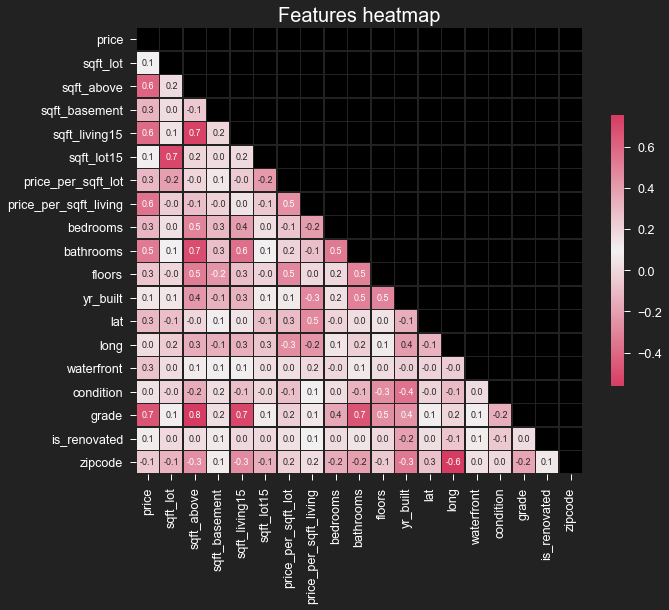

In [45]:
heatmap_DataFrame(df_model)

### Feature correlation and multicollinearity 

In [46]:
correlation_top_bottom(df.corr())

Positive correlations:
   index                  feature_combo  correlation
0    344  is_renovated and yr_renovated     0.999968
1    103     sqft_above and sqft_living     0.876534
2    102          grade and sqft_living     0.762474
3    241           grade and sqft_above     0.756217
4    263           sqft_above and grade     0.756217
5    418  sqft_living15 and sqft_living     0.756184
6    110  sqft_living and sqft_living15     0.756184
7     73      sqft_living and bathrooms     0.755519
8    271   sqft_above and sqft_living15     0.731877
9    134        sqft_lot and sqft_lot15     0.717742

----------------------------------------------------------------------
Negative correlations:
   index                       feature_combo  correlation
0    362                    zipcode and long    -0.564772
1    220              condition and yr_built    -0.365092
2    314                zipcode and yr_built    -0.346151
3    320  price_per_sqft_living and yr_built    -0.289675
4    363 

In [47]:
top_correlated_features(df_model)

,feature_combo,correlation
0,grade and sqft_above,0.756217
1,sqft_above and grade,0.756217


## Exploring features

### Individually

#### Price

In [48]:
df_model['price'].describe().to_frame().style.format("{0:,.0f}")

,price
count,"21,419"
mean,"540,735"
std,"367,939"
min,"78,000"
25%,"322,500"
50%,"450,000"
75%,"645,000"
max,"7,700,000"


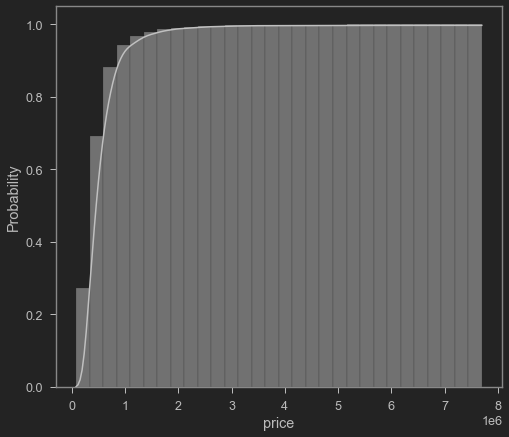

In [49]:
sns.histplot(data=df_model.price,
             bins=30,
             color='silver',
             kde=True,
             stat="probability",
             cumulative=True);

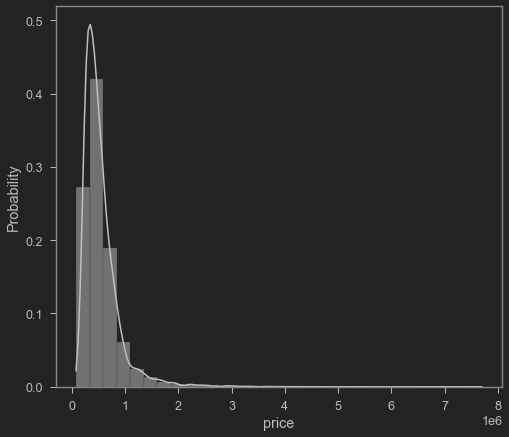

In [50]:
sns.histplot(data=df_model.price,
             bins=30,
             color='silver',
             kde=True,
             stat="probability");

##### probplot plot

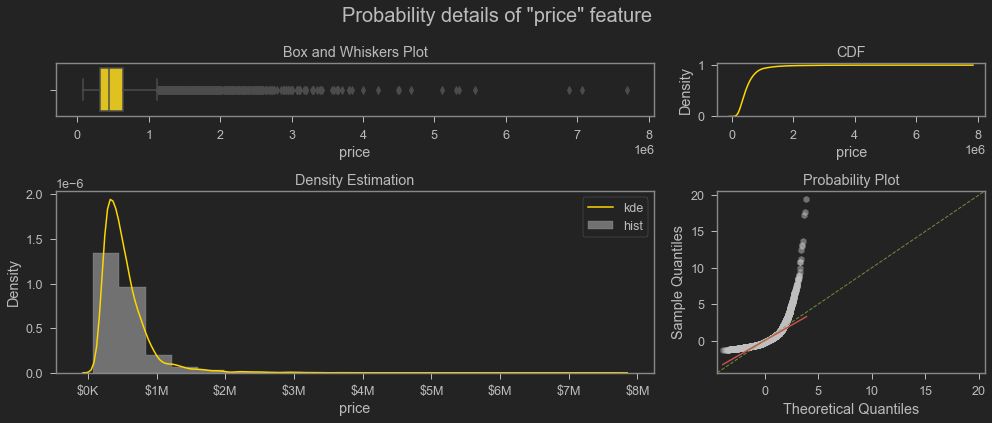

Distribution is NOT NORMAL based on Shapiro-Wilk Test and Kolmogorov-Smirnov test for goodness of fit at 95.0% confidence interval.


In [51]:
# with supressing warning of N>5000
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    feature_prob_details(df_model.price)

Slope: 310305.01, Intercept: 540734.67, r_sq: 0.711


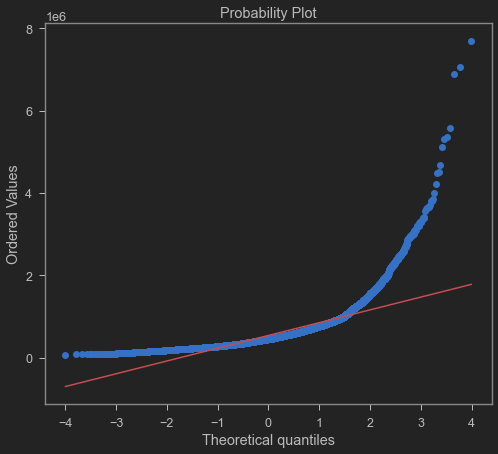

In [52]:
fig, ax = plt.subplots()
ax = slope, intercept, r = stats.probplot(df_model['price'],
                                          dist="norm",
                                          fit=True,
                                          plot=plt)[1]
print(
    f'Slope: {round(slope,2)}, Intercept: {round(intercept,2)}, r_sq: {round(r**2,4)}'
)

#### View

### check the distribution of the features

In [53]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     for column in df_model:
#         print(f'{"="*180}')
#         feature_prob_details(df_model[column])
#         print(f'{"="*180}')
#         plt.show()

### check the linearity of the features

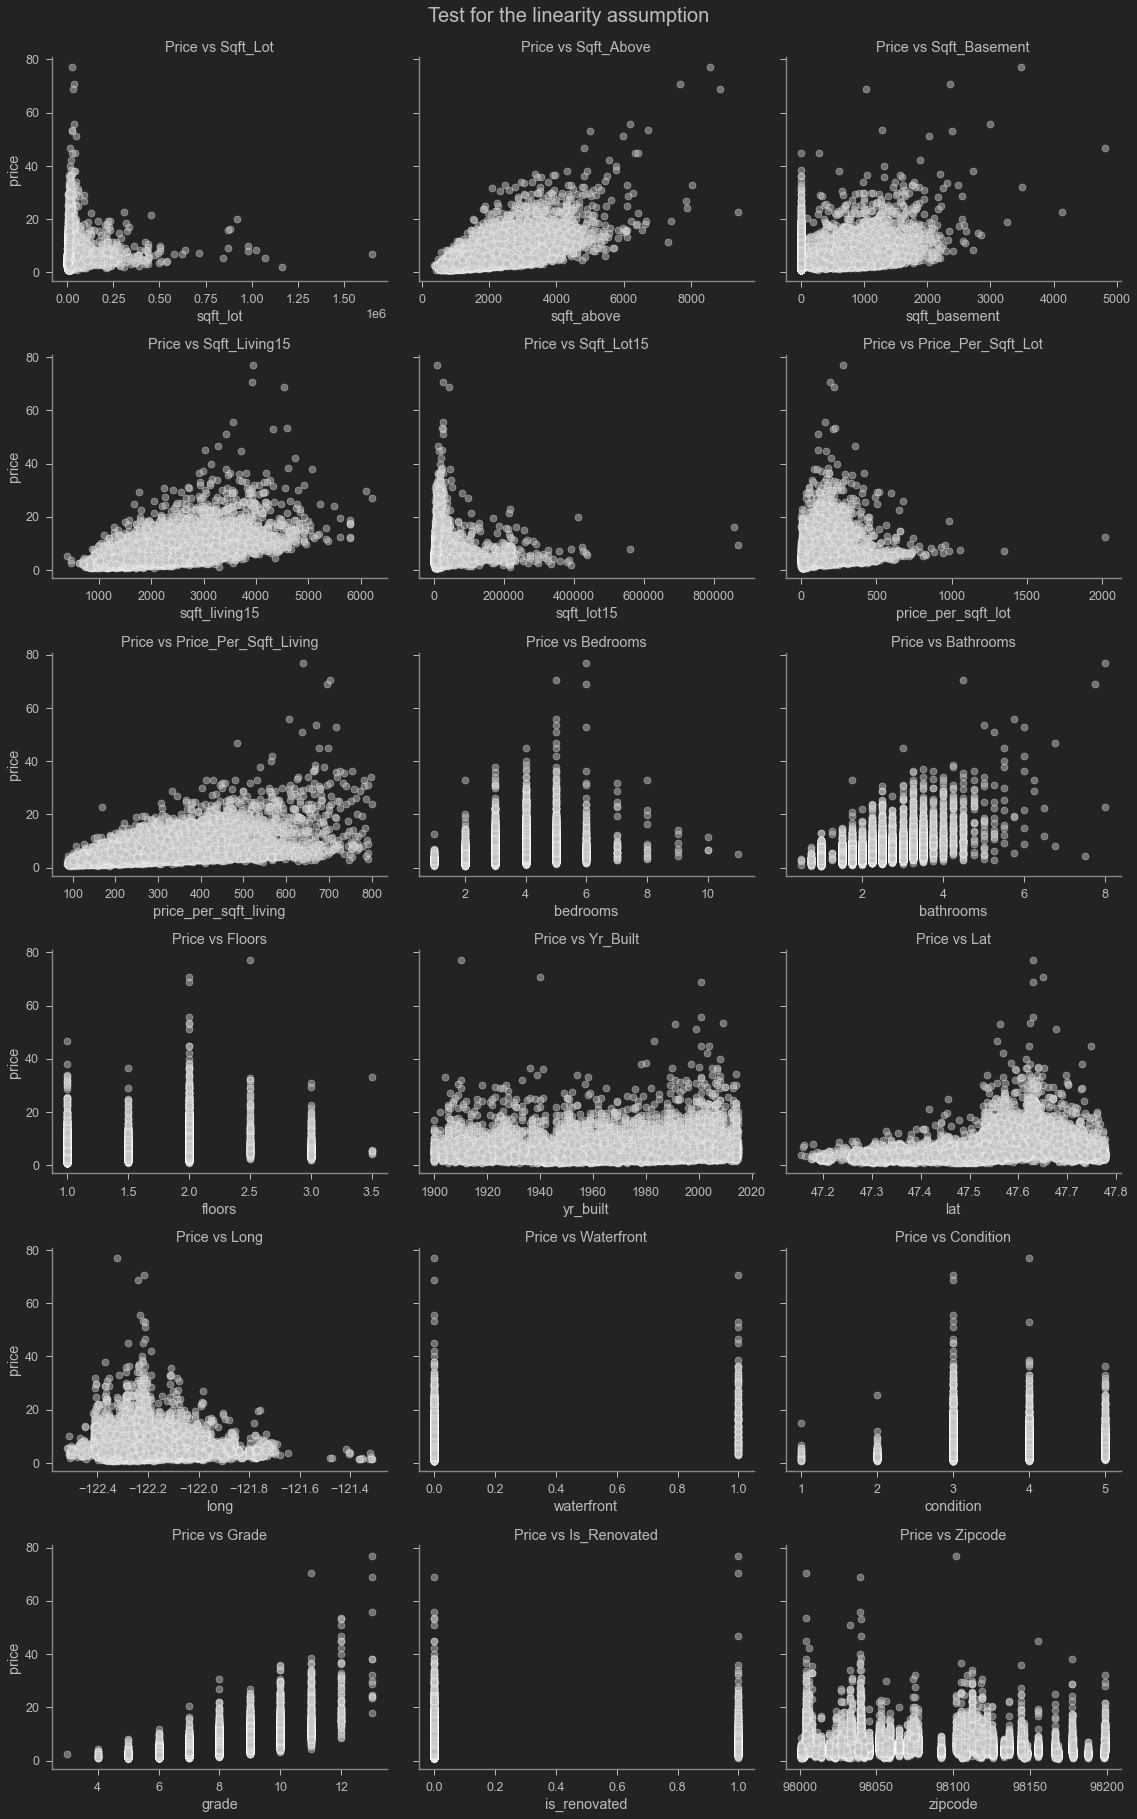

In [132]:
test_for_linearity(df_model)

### Check the normality assumptions

formula: price ~ price
Regression Analysis and Diagnostics for Price with price
Plot 1 of 19
------------------------------------------------------------------------------------------


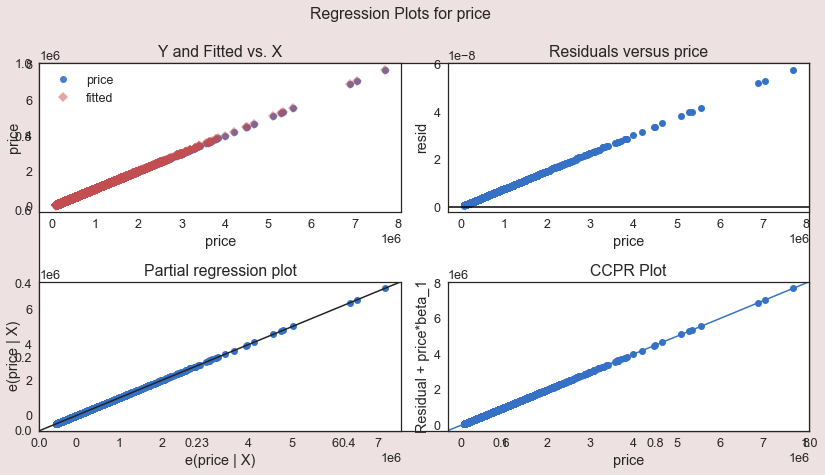

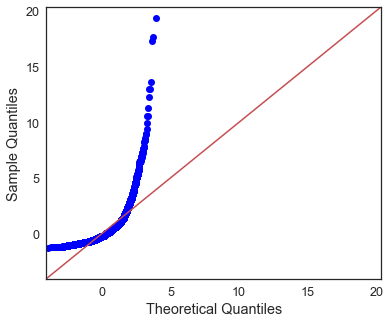

formula: price ~ sqft_lot
Regression Analysis and Diagnostics for Price with sqft_lot
Plot 2 of 19
------------------------------------------------------------------------------------------


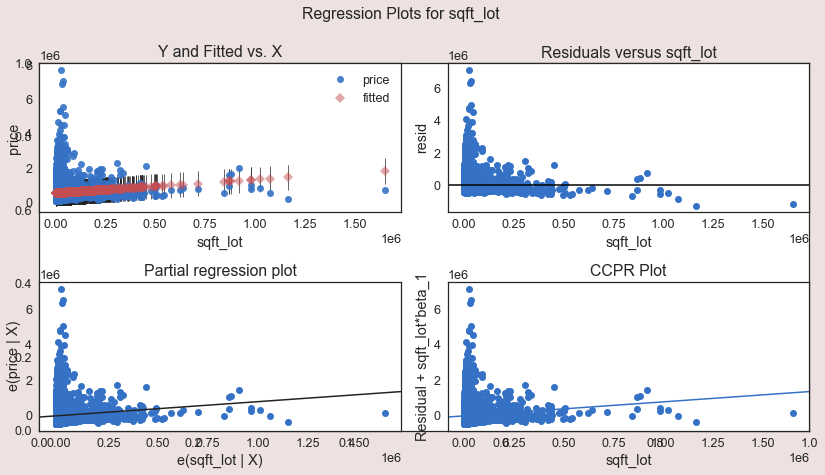

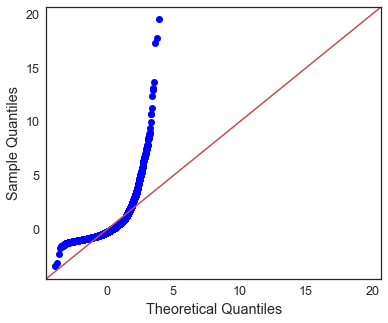

formula: price ~ sqft_above
Regression Analysis and Diagnostics for Price with sqft_above
Plot 3 of 19
------------------------------------------------------------------------------------------


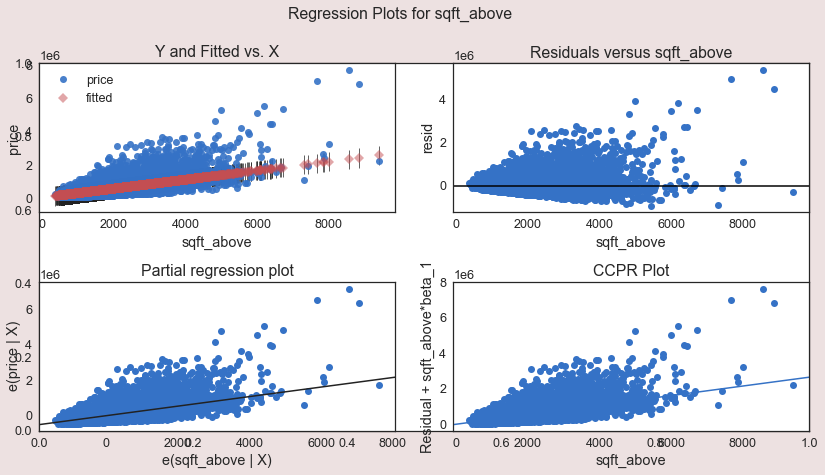

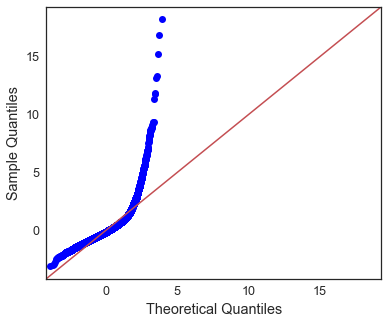

formula: price ~ sqft_basement
Regression Analysis and Diagnostics for Price with sqft_basement
Plot 4 of 19
------------------------------------------------------------------------------------------


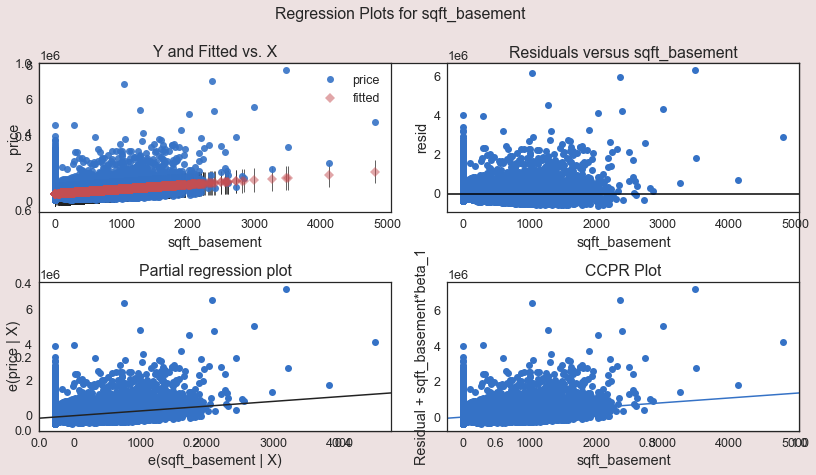

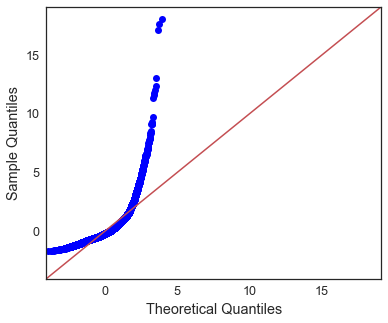

formula: price ~ sqft_living15
Regression Analysis and Diagnostics for Price with sqft_living15
Plot 5 of 19
------------------------------------------------------------------------------------------


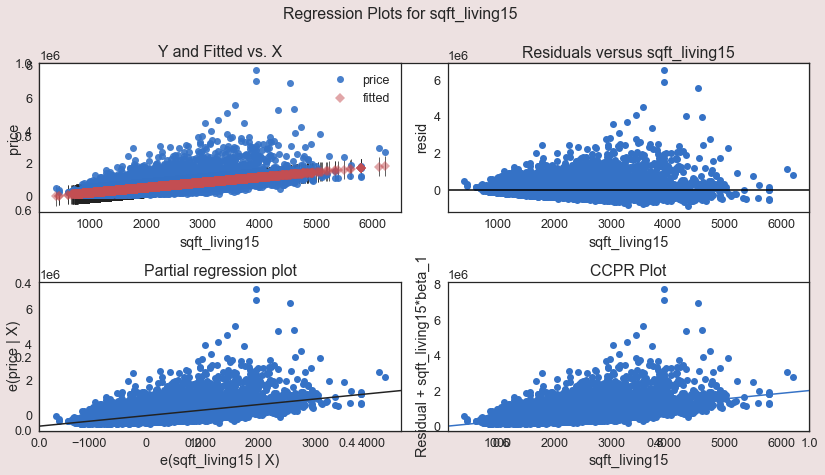

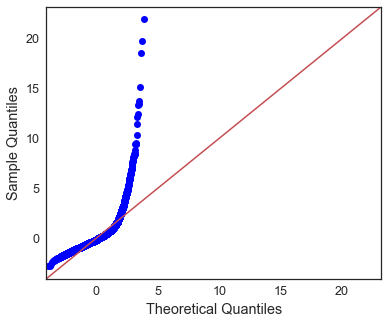

formula: price ~ sqft_lot15
Regression Analysis and Diagnostics for Price with sqft_lot15
Plot 6 of 19
------------------------------------------------------------------------------------------


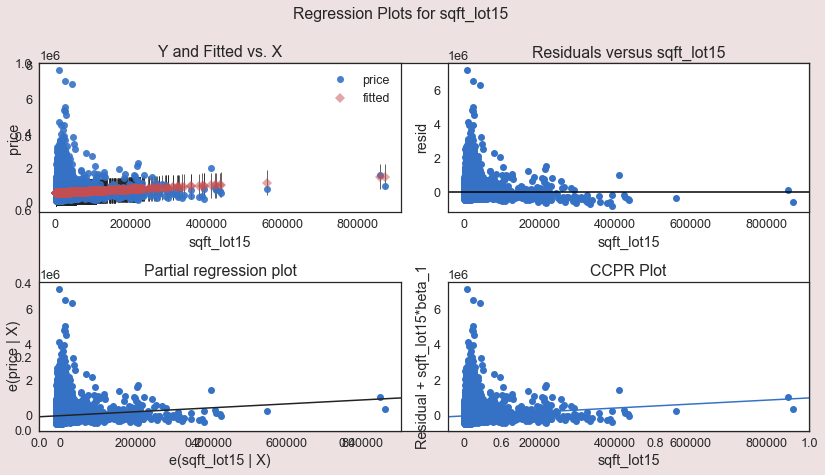

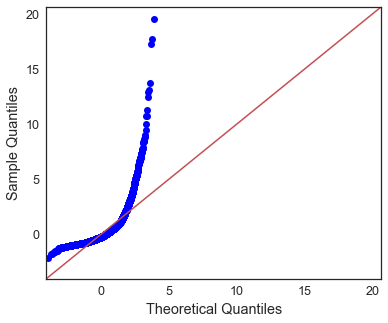

formula: price ~ price_per_sqft_lot
Regression Analysis and Diagnostics for Price with price_per_sqft_lot
Plot 7 of 19
------------------------------------------------------------------------------------------


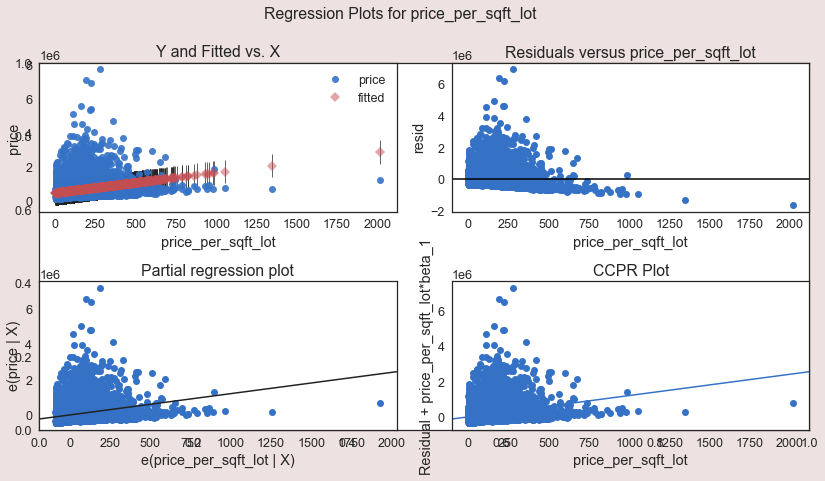

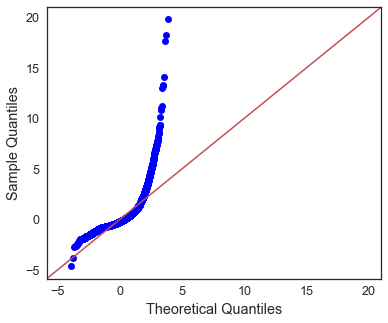

formula: price ~ price_per_sqft_living
Regression Analysis and Diagnostics for Price with price_per_sqft_living
Plot 8 of 19
------------------------------------------------------------------------------------------


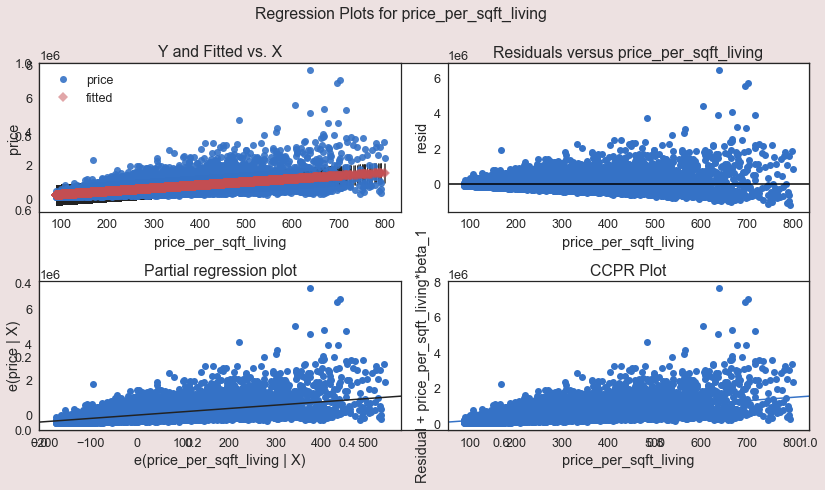

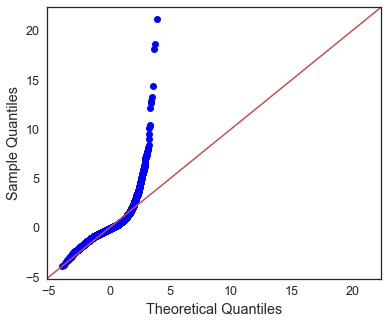

formula: price ~ bedrooms
Regression Analysis and Diagnostics for Price with bedrooms
Plot 9 of 19
------------------------------------------------------------------------------------------


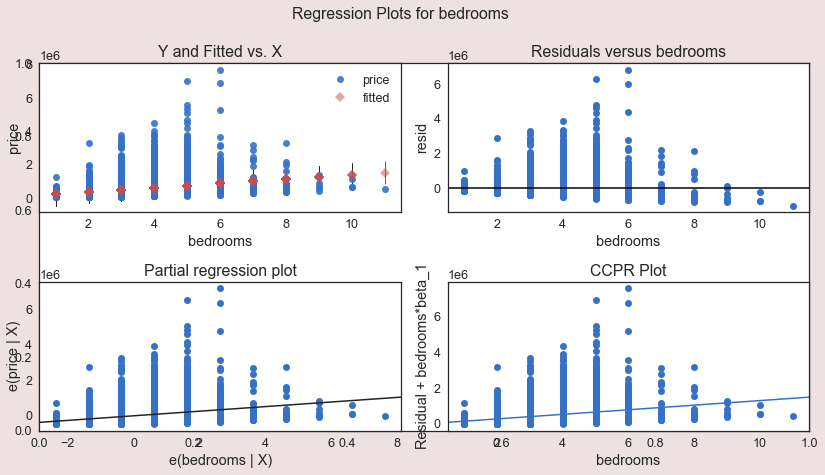

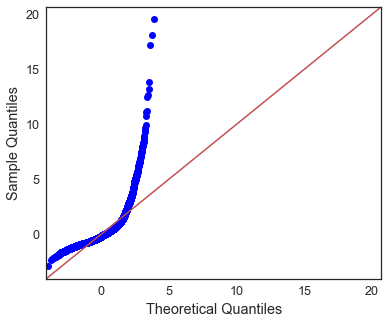

formula: price ~ bathrooms
Regression Analysis and Diagnostics for Price with bathrooms
Plot 10 of 19
------------------------------------------------------------------------------------------


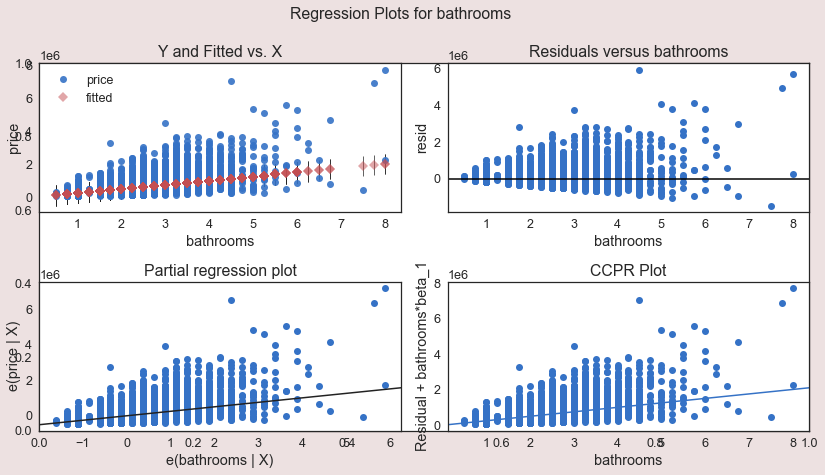

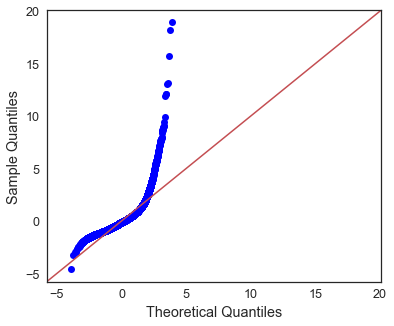

formula: price ~ floors
Regression Analysis and Diagnostics for Price with floors
Plot 11 of 19
------------------------------------------------------------------------------------------


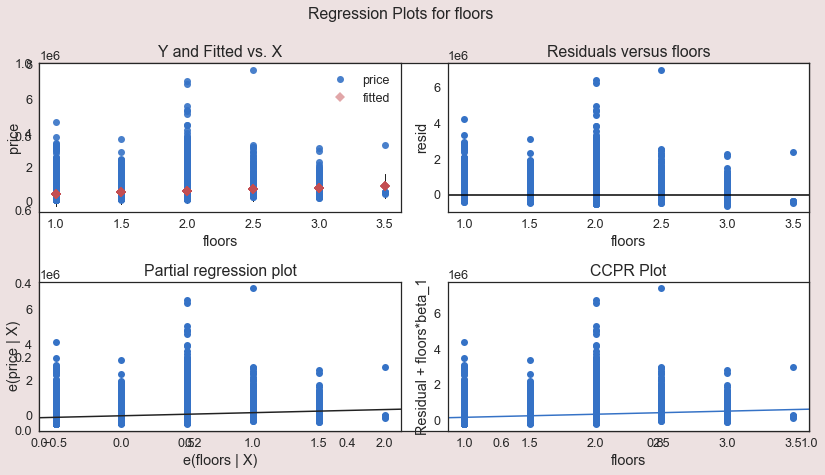

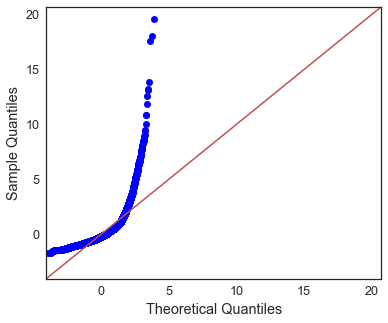

formula: price ~ yr_built
Regression Analysis and Diagnostics for Price with yr_built
Plot 12 of 19
------------------------------------------------------------------------------------------


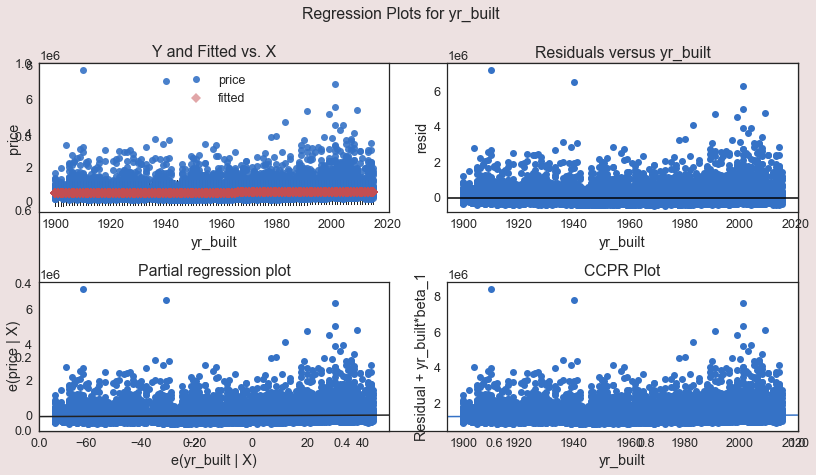

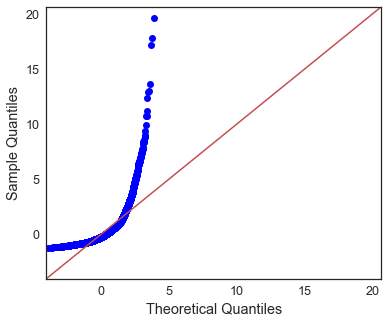

formula: price ~ lat
Regression Analysis and Diagnostics for Price with lat
Plot 13 of 19
------------------------------------------------------------------------------------------


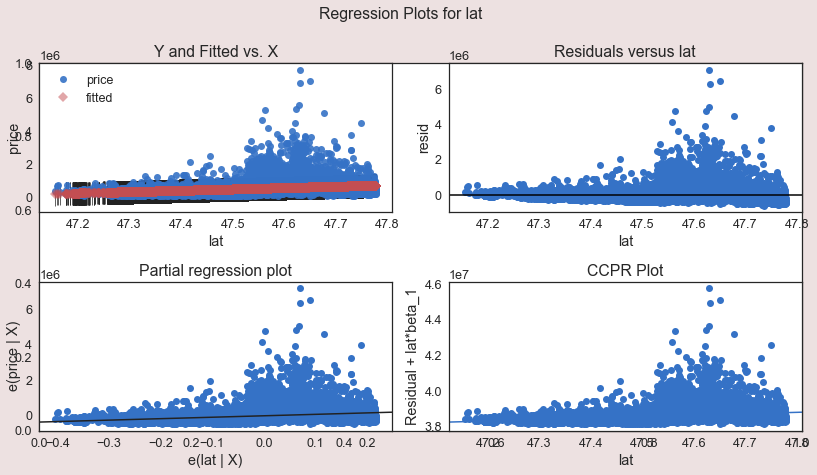

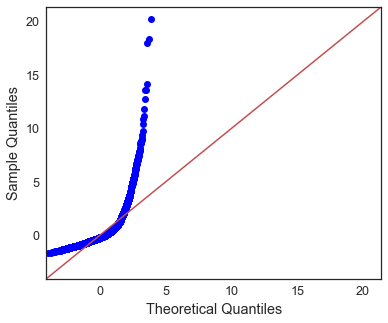

formula: price ~ long
Regression Analysis and Diagnostics for Price with long
Plot 14 of 19
------------------------------------------------------------------------------------------


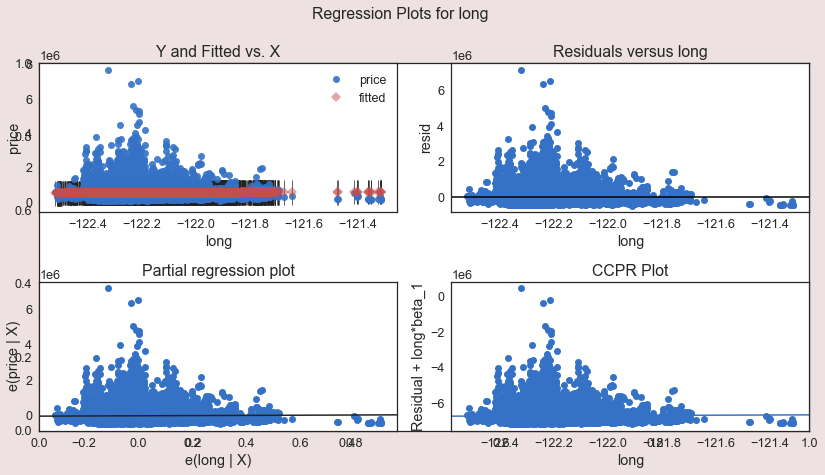

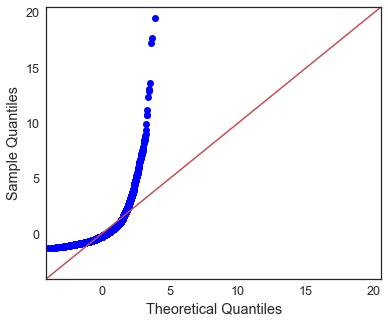

formula for regression: price ~ long
Regression Analysis and Diagnostics for Price with waterfront
Plot 15 of 19
------------------------------------------------------------------------------------------


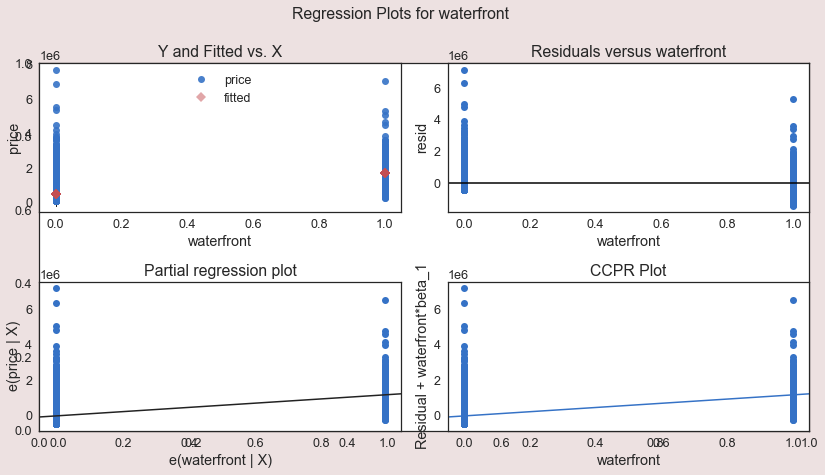

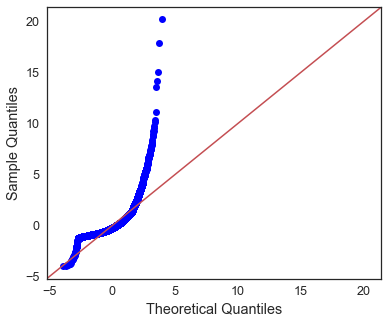

formula for regression: price ~ C(waterfront)
Regression Analysis and Diagnostics for Price with condition
Plot 16 of 19
------------------------------------------------------------------------------------------


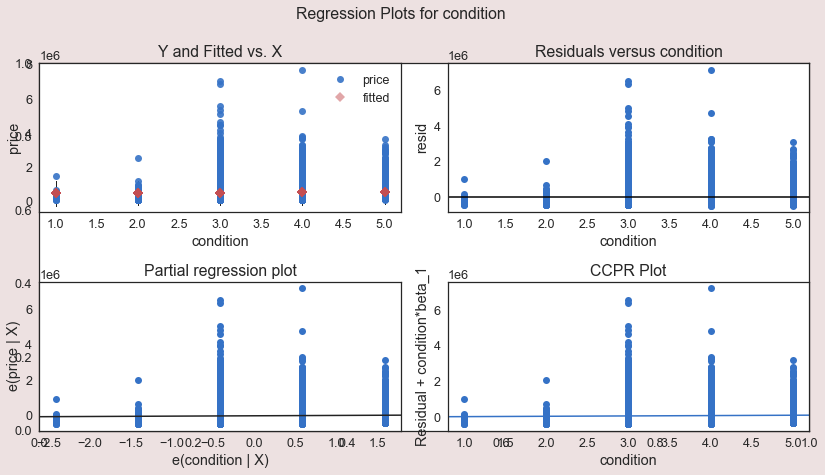

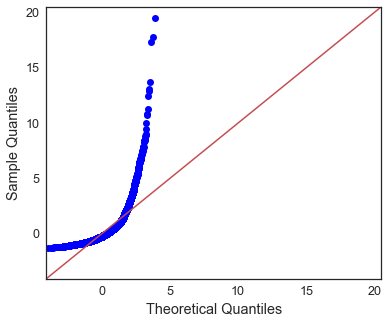

formula for regression: price ~ C(condition)
Regression Analysis and Diagnostics for Price with grade
Plot 17 of 19
------------------------------------------------------------------------------------------


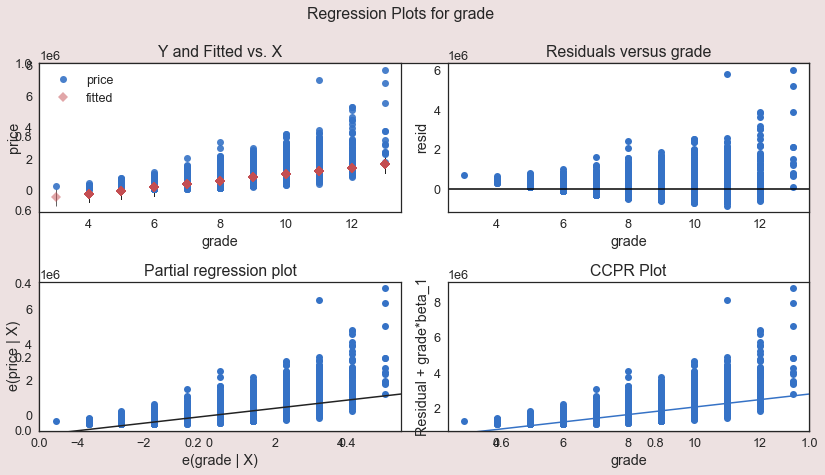

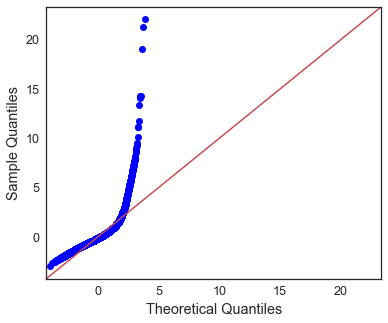

formula for regression: price ~ C(grade)
Regression Analysis and Diagnostics for Price with is_renovated
Plot 18 of 19
------------------------------------------------------------------------------------------


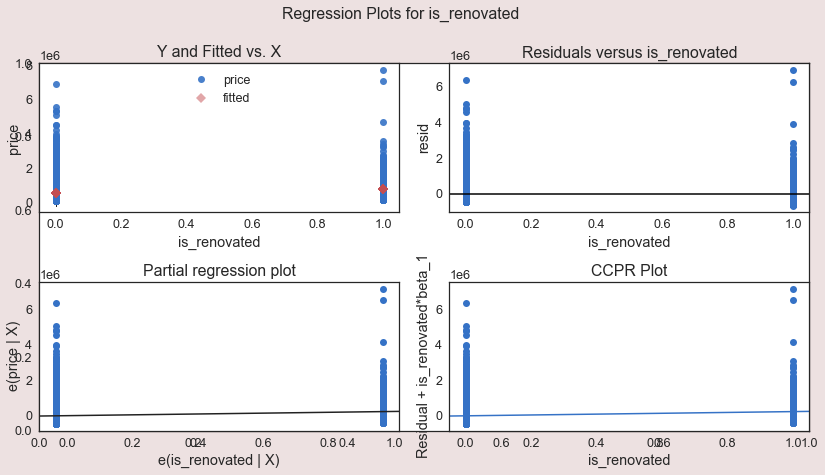

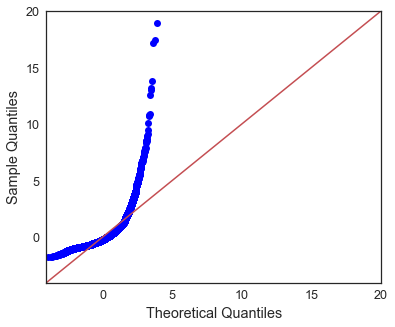

formula for regression: price ~ C(is_renovated)
Regression Analysis and Diagnostics for Price with zipcode
Plot 19 of 19
------------------------------------------------------------------------------------------


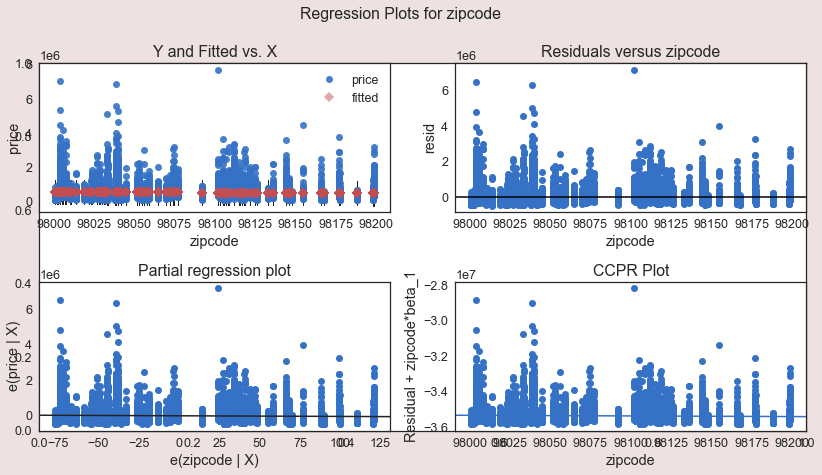

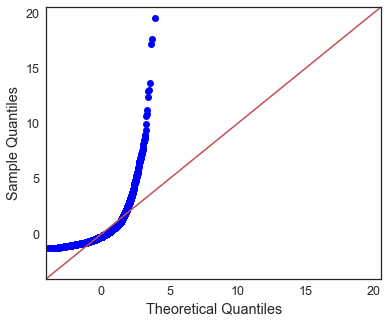

In [131]:
with plt.style.context('seaborn-white'):
    stat_list = []
    for idx, column in enumerate(df_model.columns):
        regression_target = 'price'
        if column in categorical_feat_model:
            print(f'formula for regression: {f}')
            print(
                f"Regression Analysis and Diagnostics for Price with {column}")
            print(f'Plot {idx+1} of {len(df_model.columns)}')
            print(f'{"-"*90}')

            temp_df = df_model.copy()
            temp_df = temp_df[[regression_target, column]]

            f = f'{regression_target} ~ C({column})'
            f_for_plot = f'{regression_target} ~ {column}'

            model = smf.ols(formula=f, data=temp_df).fit()
            model_for_plot = smf.ols(formula=f_for_plot, data=temp_df).fit()

            fig, axes = plt.subplots(figsize=(12, 7),
                                     facecolor='#ede1e1',
                                     edgecolor='red')
            fig = sm.graphics.plot_regress_exog(model_for_plot,
                                                column,
                                                fig=fig)
            fig.tight_layout()

            sm.graphics.qqplot(model_for_plot.resid,
                               dist=stats.norm,
                               line='45',
                               fit=True).set_size_inches(6, 5)

            temp_dict = {
                'name': column,
                'r_sq': model.rsquared,
                'intercept': model.params[0],
                'beta': model.params[1],
                'p_val': model.pvalues[1],
                'Jarque-Bera': sms.jarque_bera(model.resid)[0]
            }
            stat_list.append(temp_dict)
            plt.show()
        if column in numerical_feat_model:
            f = f'{regression_target} ~ {column}'
            print(f'formula: {f}')
            print(
                f"Regression Analysis and Diagnostics for Price with {column}")
            print(f'Plot {idx+1} of {len(df_model.columns)}')
            print(f'{"-"*90}')
            model = smf.ols(formula=f, data=df_model).fit()

            fig, axes = plt.subplots(figsize=(12, 7),
                                     facecolor='#ede1e1',
                                     edgecolor='red')
            fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
            fig.tight_layout()

            sm.graphics.qqplot(model.resid,
                               dist=stats.norm,
                               line='45',
                               fit=True).set_size_inches(6, 5)

            temp_dict = {
                'name': column,
                'r_sq': model.rsquared,
                'intercept': model.params[0],
                'beta': model.params[1],
                'p_val': model.pvalues[1],
                'Jarque-Bera': sms.jarque_bera(model.resid)[0]
            }
            stat_list.append(temp_dict)
            plt.show()

In [56]:
df_model.columns

Index(['price', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'price_per_sqft_lot', 'price_per_sqft_living', 'bedrooms',
       'bathrooms', 'floors', 'yr_built', 'lat', 'long', 'waterfront',
       'condition', 'grade', 'is_renovated', 'zipcode'],
      dtype='object')

### Cherrypicked pairs 

#### Price VS Year Built

In [57]:
# sns.jointplot(x='price',y='yr_built',data=df_model);

In [58]:
# price_vs_year_built()

#### Price VS Bedroom Count

In [59]:
# sns.jointplot(x='price',y='bedrooms',data=df_model);

In [60]:
# price_vs_bedroom_count()

### Location

#### House Location

Uncomment following cell to reproduce following image.
<img src="./assets/location.png"
     alt="Map!"
     style="float: center; margin-center: 2px;">

In [61]:
# get_location()

#### Average Price by Zipcode

In [62]:
# # grouping by zipcode and aggregating by average price
# df_mean_price_by_zip = df.groupby(by='zipcode').mean().reset_index()
# df_mean_price_by_zip[['zipcode', 'price'
#                       ]].sort_values(by='price',
#                                      ascending=False).reset_index(drop='index')

Uncomment following cell to reproduce following image.
<img src="./assets/zipcode_image.png"
     alt="Map!"
     style="float: center; margin-center: 2px;">

In [63]:
# average_price_by_zipcode()

# Regression

### Initial simple OLS

#### On all data

Dependent variable is price. A list of features were regressed. That list is:
```python
for_simple_ols = ['price', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'price_per_sqft_lot', 'price_per_sqft_living', 'bedrooms',
       'bathrooms', 'floors', 'yr_built', 'lat', 'long', 'waterfront',
       'condition', 'grade', 'is_renovated', 'zipcode']
```

In [65]:
# # Data from calucation for checking normality assumption code
# df_stat = pd.DataFrame(stat_list)
# df_stat.sort_values(by='r_sq',ascending=False).style.set_precision(4).set_properties(**{'color': 'lawngreen'})

### initial Multiple OLS

#### Whole DataFrame

In [66]:
print(
    f"Independents variables: {list(df_model.columns)}\nDependant variable: '{df_model.price.name}'\n\n"
)
# another look at the features
print('categorical features:', categorical_feat_model)
print('numerical features:', numerical_feat_model)

Independents variables: ['price', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price_per_sqft_lot', 'price_per_sqft_living', 'bedrooms', 'bathrooms', 'floors', 'yr_built', 'lat', 'long', 'waterfront', 'condition', 'grade', 'is_renovated', 'zipcode']
Dependant variable: 'price'


categorical features: ['waterfront', 'condition', 'grade', 'is_renovated', 'zipcode']
numerical features: ['price', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price_per_sqft_lot', 'price_per_sqft_living', 'bedrooms', 'bathrooms', 'floors', 'yr_built', 'lat', 'long']


NOTE TO SELF: Add constant

MODEL # 1

Dropped Features: []
Formula for regression: price ~ sqft_lot + sqft_above + sqft_basement + sqft_living15 + sqft_lot15 + price_per_sqft_lot + price_per_sqft_living + bedrooms + bathrooms + floors + yr_built + lat + long + C(waterfront) + C(condition) + C(grade) + C(is_renovated) + C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     2204.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:22:25   Log-Likelihood:            -2.7908e+05
No. Observations:               21419   AIC:                         5.584e+05
Df Residuals:                   21320   BIC:                         5.592e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -6.155e+05   4.26e+06     -0.145      0.885   -8.96e+06    7.73e+06
C(waterfront)[T.1]     3.646e+05   1.01e+04     36.223      0.000    3.45e+05    3.84e+05
C(condition)[T.2]      2.204e+04   2.27e+04      0.969      0.333   -2.25e+04    6.66e+04
C(condition)[T.3]     -1.122e+04   2.11e+04     -0.531      0.595   -5.27e+04    3.02e+04
C(condition)[T.4]       553.8502   2.12e+04      0.026      0.979   -4.09e+04     4.2e+04
C(condition)[T.5]      1.896e+04   2.13e+04      0.891      0.373   -2.28e+04    6.07e+04
C(grade)[T.4]          2.252e+05   1.13e+05      1.995      0.046    3919.010    4.46e+05
C(grade)[T.5]          2.844e+05   1.11e+05      2.560      0.010    6.66e+04    5.02e+05
C(grade)[T.6]          2.998e+05   1.11e+05      2.703      0.007    8.24e+04    5.17e+05
C(grade)[T.7]          3.069e+05   1.11e+05      2.767      0.006    8.95e+04    5.24e+05
C(grade)[T.8]          3.061e+05   1.11e+05      2.760      0.006    8.87e+04    5.24e+05
C(grade)[T.9]          3.285e+05   1.11e+05      2.960      0.003    1.11e+05    5.46e+05
C(grade)[T.10]         3.943e+05   1.11e+05      3.551      0.000    1.77e+05    6.12e+05
C(grade)[T.11]         5.094e+05   1.11e+05      4.582      0.000    2.92e+05    7.27e+05
C(grade)[T.12]         7.982e+05   1.12e+05      7.142      0.000    5.79e+05    1.02e+06
C(grade)[T.13]         1.614e+06   1.16e+05     13.964      0.000    1.39e+06    1.84e+06
C(is_renovated)[T.1]    2.97e+04   4442.364      6.686      0.000     2.1e+04    3.84e+04
C(zipcode)[T.98002]    1.465e+04      1e+04      1.462      0.144   -4988.605    3.43e+04
C(zipcode)[T.98003]   -8377.4905   8957.612     -0.935      0.350   -2.59e+04    9180.103
C(zipcode)[T.98004]     1.51e+05   1.67e+04      9.026      0.000    1.18e+05    1.84e+05
C(zipcode)[T.98005]   -1.372e+04   1.75e+04     -0.786      0.432   -4.79e+04    2.05e+04
C(zipcode)[T.98006]   -1.621e+04   1.43e+04     -1.132      0.258   -4.43e+04    1.19e+04
C(zipcode)[T.98007]   -2.286e+04    1.8e+04     -1.267      0.205   -5.82e+04    1.25e+04
C(zipcode)[T.98008]   -1.382e+04   1.71e+04     -0.807      0.420   -4.74e+04    1.97e+04
C(zipcode)[T.98010]   -2.651e+04   1.53e+04     -1.736      0.083   -5.64e+04    3421.600
C(zipcode)[T.98011]   -4.236e+04   2.22e+04     -1.912      0.056   -8.58e+04    1059.892
C(zipcode)[T.98014]   -2.184e+04   2.44e+04     -0.897      0.370   -6.96e+04    2.59e+04
C(zipcode)[T.98019]   -3.424e+04    2.4e+04     -1.427      0.154   -8.13e+04    1.28e+04
C(zipcode)[T.98022]      79.8565   1.33e+04      0.006      0.995   -2.59e+04    2.61e+04
C(zipcode)[T.98023]   -1.894e+04   8241.921     -2.298      0.022   -3.51e+04   -2782.618
C(zipcode)[T.98024]   -1.454e+04   2.15e+04     -0.677      0.498   -5.66e+04    2.75e+04
C(zipcode)[T.98027]   -

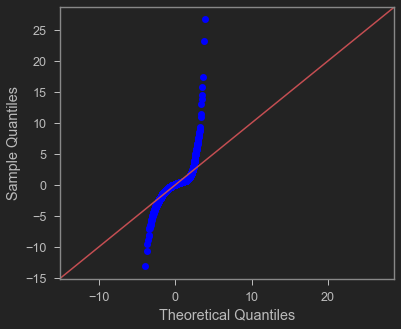

In [147]:
x1 = OLS_sm(df=df_model, target='price', verbose=True, show_summary=True)
sm.graphics.qqplot(x1.resid,dist=stats.norm,line='45',fit=True).set_size_inches(6, 5)

In [69]:
print(
    f'Model 1: r-sq value is {x1.rsquared.round(4)}, and adj.r-sq value is {x1.rsquared_adj.round(4)}'
)

Model 1: r-sq value is 0.9102, and adj.r-sq value is 0.9097


MODEL # 2

In [72]:
## Reasoning for droping
# price is target
# 'price_per_sqft_lot','price_per_sqft_living', - possible information leakage, i.e. multicolinearity.
# lat, long - already captured in the zipcode variable
x2 = OLS_sm(
    df=df_model,
    target='price',
    drop=['price_per_sqft_lot', 'price_per_sqft_living', 'lat', 'long'],
    verbose=True,
    show_summary=True)

Dropped Features: ['price_per_sqft_lot', 'price_per_sqft_living', 'lat', 'long']
Formula for regression: price ~ sqft_lot + sqft_above + sqft_basement + sqft_living15 + sqft_lot15 + bedrooms + bathrooms + floors + yr_built + C(waterfront) + C(condition) + C(grade) + C(is_renovated) + C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1074.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:17:47   Log-Likelihood:            -2.8619e+05
No. Observations:               21419   AIC:                         5.726e+05
Df Residuals:                   21324   BIC:                         5.733e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8.431e+05   1.98e+05      4.251      0.000    4.54e+05    1.23e+06
C(waterfront)[T.1]    8.216e+05   1.33e+04     61.933      0.000    7.96e+05    8.48e+05
C(condition)[T.2]      8.98e+04   3.17e+04      2.835      0.005    2.77e+04    1.52e+05
C(condition)[T.3]     1.063e+05   2.94e+04      3.612      0.000    4.86e+04    1.64e+05
C(condition)[T.4]     1.347e+05   2.94e+04      4.575      0.000     7.7e+04    1.92e+05
C(condition)[T.5]     1.778e+05   2.96e+04      6.003      0.000     1.2e+05    2.36e+05
C(grade)[T.4]        -7.879e+04   1.57e+05     -0.501      0.616   -3.87e+05    2.29e+05
C(grade)[T.5]        -1.236e+05   1.55e+05     -0.798      0.425   -4.27e+05     1.8e+05
C(grade)[T.6]        -1.242e+05   1.54e+05     -0.804      0.421   -4.27e+05    1.79e+05
C(grade)[T.7]        -1.186e+05   1.54e+05     -0.768      0.442   -4.21e+05    1.84e+05
C(grade)[T.8]        -8.899e+04   1.54e+05     -0.576      0.565   -3.92e+05    2.14e+05
C(grade)[T.9]        -8926.9530   1.55e+05     -0.058      0.954   -3.12e+05    2.94e+05
C(grade)[T.10]        1.173e+05   1.55e+05      0.758      0.448   -1.86e+05     4.2e+05
C(grade)[T.11]        3.237e+05   1.55e+05      2.090      0.037    2.01e+04    6.27e+05
C(grade)[T.12]        7.515e+05   1.56e+05      4.826      0.000    4.46e+05    1.06e+06
C(grade)[T.13]        1.869e+06   1.61e+05     11.613      0.000    1.55e+06    2.18e+06
C(is_renovated)[T.1]   6.47e+04   6173.882     10.479      0.000    5.26e+04    7.68e+04
C(zipcode)[T.98002]   7364.2776   1.37e+04      0.537      0.591   -1.95e+04    3.43e+04
C(zipcode)[T.98003]  -3888.1027   1.24e+04     -0.314      0.753   -2.81e+04    2.03e+04
C(zipcode)[T.98004]   7.476e+05   1.21e+04     61.837      0.000    7.24e+05    7.71e+05
C(zipcode)[T.98005]   2.833e+05   1.46e+04     19.452      0.000    2.55e+05    3.12e+05
C(zipcode)[T.98006]   2.459e+05    1.1e+04     22.439      0.000    2.24e+05    2.67e+05
C(zipcode)[T.98007]   2.384e+05   1.55e+04     15.419      0.000    2.08e+05    2.69e+05
C(zipcode)[T.98008]   2.674e+05   1.23e+04     21.690      0.000    2.43e+05    2.92e+05
C(zipcode)[T.98010]   5.561e+04   1.76e+04      3.162      0.002    2.11e+04    9.01e+04
C(zipcode)[T.98011]   1.236e+05   1.38e+04      8.980      0.000    9.66e+04    1.51e+05
C(zipcode)[T.98014]   9.361e+04   1.64e+04      5.705      0.000    6.15e+04    1.26e+05
C(zipcode)[T.98019]    8.95e+04   1.39e+04      6.437      0.000    6.22e+04    1.17e+05
C(zipcode)[T.98022]   1.234e+04   1.31e+04      0.939      0.348   -1.34e+04    3.81e+04
C(zipcode)[T.98023]  -3.393e+04   1.07e+04     -3.162      0.002    -5.5e+04   -1.29e+04
C(zipcode)[T.98024]   1.513e+05   1.94e+04      7.799      0.000    1.13e+05    1.89e+05
C(zipcode)[T.98027]   1.546e+05   1.12e+04     13.762    

In [ ]:
print(
    f'Model 2: r-sq value is {x2.rsquared.round(4)}, and adj.r-sq value is {x2.rsquared_adj.round(4)}'
)

MODEL # 3

In [74]:
x3 = OLS_sm(df=df_model,
            target='price',
            drop=['price_per_sqft_lot', 'price_per_sqft_living'],
            verbose=True,
            show_summary=True)

Dropped Features: ['price_per_sqft_lot', 'price_per_sqft_living']
Formula for regression: price ~ sqft_lot + sqft_above + sqft_basement + sqft_living15 + sqft_lot15 + bedrooms + bathrooms + floors + yr_built + lat + long + C(waterfront) + C(condition) + C(grade) + C(is_renovated) + C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1053.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:19:19   Log-Likelihood:            -2.8617e+05
No. Observations:               21419   AIC:                         5.725e+05
Df Residuals:                   21322   BIC:                         5.733e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -3.458e+07   5.91e+06     -5.851      0.000   -4.62e+07    -2.3e+07
C(waterfront)[T.1]    8.205e+05   1.33e+04     61.842      0.000    7.94e+05    8.46e+05
C(condition)[T.2]     8.973e+04   3.17e+04      2.835      0.005    2.77e+04    1.52e+05
C(condition)[T.3]     1.062e+05   2.94e+04      3.611      0.000    4.85e+04    1.64e+05
C(condition)[T.4]      1.35e+05   2.94e+04      4.588      0.000    7.73e+04    1.93e+05
C(condition)[T.5]      1.78e+05   2.96e+04      6.014      0.000     1.2e+05    2.36e+05
C(grade)[T.4]        -7.913e+04   1.57e+05     -0.504      0.615   -3.87e+05    2.29e+05
C(grade)[T.5]        -1.234e+05   1.55e+05     -0.798      0.425   -4.26e+05     1.8e+05
C(grade)[T.6]        -1.261e+05   1.54e+05     -0.817      0.414   -4.29e+05    1.76e+05
C(grade)[T.7]         -1.21e+05   1.54e+05     -0.784      0.433   -4.24e+05    1.81e+05
C(grade)[T.8]        -9.193e+04   1.54e+05     -0.596      0.552   -3.95e+05    2.11e+05
C(grade)[T.9]        -1.171e+04   1.54e+05     -0.076      0.940   -3.14e+05    2.91e+05
C(grade)[T.10]        1.147e+05   1.55e+05      0.742      0.458   -1.88e+05    4.18e+05
C(grade)[T.11]          3.2e+05   1.55e+05      2.068      0.039    1.67e+04    6.23e+05
C(grade)[T.12]        7.501e+05   1.56e+05      4.821      0.000    4.45e+05    1.06e+06
C(grade)[T.13]        1.866e+06   1.61e+05     11.604      0.000    1.55e+06    2.18e+06
C(is_renovated)[T.1]  6.507e+04   6169.710     10.546      0.000     5.3e+04    7.72e+04
C(zipcode)[T.98002]   1.999e+04   1.39e+04      1.434      0.152   -7327.625    4.73e+04
C(zipcode)[T.98003]  -1.353e+04   1.25e+04     -1.085      0.278    -3.8e+04    1.09e+04
C(zipcode)[T.98004]   7.096e+05   2.26e+04     31.370      0.000    6.65e+05    7.54e+05
C(zipcode)[T.98005]   2.544e+05   2.42e+04     10.530      0.000    2.07e+05    3.02e+05
C(zipcode)[T.98006]   2.309e+05   1.98e+04     11.676      0.000    1.92e+05     2.7e+05
C(zipcode)[T.98007]   2.153e+05    2.5e+04      8.615      0.000    1.66e+05    2.64e+05
C(zipcode)[T.98008]   2.498e+05   2.37e+04     10.549      0.000    2.03e+05    2.96e+05
C(zipcode)[T.98010]   1.109e+05   2.12e+04      5.228      0.000    6.93e+04    1.52e+05
C(zipcode)[T.98011]   6.259e+04   3.08e+04      2.031      0.042    2184.988    1.23e+05
C(zipcode)[T.98014]   1.237e+05   3.39e+04      3.653      0.000    5.73e+04     1.9e+05
C(zipcode)[T.98019]   8.568e+04   3.34e+04      2.567      0.010    2.03e+04    1.51e+05
C(zipcode)[T.98022]   8.954e+04   1.84e+04      4.863      0.000    5.35e+04    1.26e+05
C(zipcode)[T.98023]  -5.453e+04   1.15e+04     -4.755      0.000    -7.7e+04   -3.21e+04
C(zipcode)[T.98024]   1.882e+05   2.98e+04      6.312      0.000     1.3e+05    2.47e+05
C(zipcode)[T.98027]   1.686e+05   2.03e+04      8.319    

In [75]:
print(
    f'Model 3: r-sq value is {x3.rsquared.round(4)}, and adj.r-sq value is {x3.rsquared_adj.round(4)}'
)

Model 3: r-sq value is 0.8259, and adj.r-sq value is 0.8251


## train-test split

### For Statsmodels

In [76]:
df_model_train, df_model_test = train_test_split(df_model,
                                                 test_size=0.3,
                                                 random_state=13)

### For scikit-learn

ONE HOT

In [77]:
categorical_feat_model

['waterfront', 'condition', 'grade', 'is_renovated', 'zipcode']

In [102]:
## column name with categories
## only apply on confirmed categorical data

# temp_dict = {}
# for column in df_model[categorical_feat_model]:
# #     print(column)
# #     print(list(df_model[column].value_counts().to_dict().keys()))
#     temp_dict[column] = list(df_model[column].value_counts().to_dict().keys())
# temp_dict

In [135]:
df_model_processed_ohe = pd.get_dummies(df_model,
                              columns=categorical_feat_model,
                              sparse=False,
                              drop_first=True)
df_model_processed_ohe

,price,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price_per_sqft_lot,price_per_sqft_living,bedrooms,bathrooms,floors,yr_built,lat,long,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,is_renovated_1,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,...,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,5650,1180,0,1340,5650,39.274336,188.050847,3,1.00,1.0,1955,47.5112,-122.257,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,7242,2170,400,1690,7639,74.288870,209.338521,3,2.25,2.0,1951,47.7210,-122.319,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,10000,770,0,2720,8062,18.000000,233.766234,2,1.00,1.0,1933,47.7379,-122.233,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,5000,1050,910,1360,5000,120.800000,308.163265,4,3.00,1.0,1965,47.5208,-122.393,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,8080,1680,0,1800,7503,63.118812,303.571429,3,2.00,1.0,1987,47.6168,-122.045,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,360000.0,1131,1530,0,1530,1509,318.302387,235.294118,3,2.50,3.0,2009,47.6993,-122.346,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21416,400000.0,5813,2310,0,1830,7200,68.811285,173.160173,4,2.50,2.0,2014,47.5107,-122.362,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21417,402101.0,1350,1020,0,1020,2007,297.852593,394.216667,2,0.75,2.0,2009,47.5944,-122.299,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21418,400000.0,2388,1600,0,1410,1287,167.504188,250.000000,3,2.50,2.0,2004,47.5345,-122.069,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
# df_model_ohe = pd.get_dummies(df_model[categorical_feat_model],
#                               prefix=categorical_feat_model,
#                               columns=categorical_feat_model,
#                               sparse=False,
#                               drop_first=True)

In [109]:
# df_model_sans_cate_var = df_model.drop(categorical_feat_model,axis=1)

In [148]:
# df_model_processed_ohe = pd.concat([df_model_sans_cate_var, df_model_ohe], axis=1)
# df_model_processed_ohe

TRANSFORM

SPLIT

In [138]:
# Full Sample target variable and independent variables
X = df_model_processed_ohe.drop(['price'], axis = 1).copy()
y = df_model_processed_ohe['price'].copy()

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=13)

#### On train data

based on model # 2 assumptions

##### Statsmodels

In [139]:
# train data
XX=OLS_sm(df_model_train,
       drop=['price_per_sqft_lot', 'price_per_sqft_living', 'lat', 'long'],
       verbose=True,
       show_summary=True)

Dropped Features: ['price_per_sqft_lot', 'price_per_sqft_living', 'lat', 'long']
Formula for regression: price ~ sqft_lot + sqft_above + sqft_basement + sqft_living15 + sqft_lot15 + bedrooms + bathrooms + floors + yr_built + C(waterfront) + C(condition) + C(grade) + C(is_renovated) + C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     743.8
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:19:43   Log-Likelihood:            -2.0047e+05
No. Observations:               14993   AIC:                         4.011e+05
Df Residuals:                   14898   BIC:                         4.019e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             9.656e+05   2.16e+05      4.464      0.000    5.42e+05    1.39e+06
C(waterfront)[T.1]    8.127e+05   1.55e+04     52.418      0.000    7.82e+05    8.43e+05
C(condition)[T.2]     1.143e+05   3.58e+04      3.195      0.001    4.42e+04    1.84e+05
C(condition)[T.3]     1.267e+05   3.29e+04      3.850      0.000    6.22e+04    1.91e+05
C(condition)[T.4]     1.541e+05   3.29e+04      4.681      0.000    8.96e+04    2.19e+05
C(condition)[T.5]     2.015e+05   3.31e+04      6.081      0.000    1.37e+05    2.66e+05
C(grade)[T.4]        -5.835e+04    1.6e+05     -0.364      0.716   -3.73e+05    2.56e+05
C(grade)[T.5]        -1.103e+05   1.57e+05     -0.704      0.481   -4.17e+05    1.97e+05
C(grade)[T.6]        -1.118e+05   1.56e+05     -0.715      0.475   -4.18e+05    1.95e+05
C(grade)[T.7]        -1.061e+05   1.56e+05     -0.679      0.497   -4.13e+05       2e+05
C(grade)[T.8]        -7.599e+04   1.56e+05     -0.486      0.627   -3.82e+05    2.31e+05
C(grade)[T.9]         2370.9755   1.56e+05      0.015      0.988   -3.04e+05    3.09e+05
C(grade)[T.10]        1.266e+05   1.57e+05      0.809      0.419    -1.8e+05    4.34e+05
C(grade)[T.11]        3.352e+05   1.57e+05      2.136      0.033    2.76e+04    6.43e+05
C(grade)[T.12]        8.127e+05   1.58e+05      5.142      0.000    5.03e+05    1.12e+06
C(grade)[T.13]        1.658e+06   1.66e+05     10.005      0.000    1.33e+06    1.98e+06
C(is_renovated)[T.1]  5.843e+04   7402.664      7.893      0.000    4.39e+04    7.29e+04
C(zipcode)[T.98002]   6132.2076   1.64e+04      0.375      0.708    -2.6e+04    3.82e+04
C(zipcode)[T.98003]  -5169.3621    1.5e+04     -0.344      0.731   -3.46e+04    2.43e+04
C(zipcode)[T.98004]   7.502e+05   1.46e+04     51.357      0.000    7.22e+05    7.79e+05
C(zipcode)[T.98005]   2.845e+05   1.76e+04     16.167      0.000     2.5e+05    3.19e+05
C(zipcode)[T.98006]   2.456e+05   1.33e+04     18.502      0.000     2.2e+05    2.72e+05
C(zipcode)[T.98007]   2.362e+05   1.84e+04     12.805      0.000       2e+05    2.72e+05
C(zipcode)[T.98008]   2.645e+05   1.48e+04     17.858      0.000    2.35e+05    2.94e+05
C(zipcode)[T.98010]   5.486e+04   2.04e+04      2.684      0.007    1.48e+04    9.49e+04
C(zipcode)[T.98011]   1.207e+05   1.67e+04      7.234      0.000     8.8e+04    1.53e+05
C(zipcode)[T.98014]   8.493e+04   1.99e+04      4.276      0.000     4.6e+04    1.24e+05
C(zipcode)[T.98019]   8.629e+04   1.63e+04      5.283      0.000    5.43e+04    1.18e+05
C(zipcode)[T.98022]   1.369e+04   1.61e+04      0.848      0.396    -1.8e+04    4.53e+04
C(zipcode)[T.98023]  -3.533e+04    1.3e+04     -2.715      0.007   -6.08e+04   -9819.605
C(zipcode)[T.98024]   1.462e+05   2.28e+04      6.408      0.000    1.01e+05    1.91e+05
C(zipcode)[T.98027]   1.476e+05   1.37e+04     10.807    

In [141]:
p_vals = XX.pvalues

In [143]:
p_vals[p_vals>.05]

C(grade)[T.4]          0.715870
C(grade)[T.5]          0.481498
C(grade)[T.6]          0.474642
C(grade)[T.7]          0.497157
C(grade)[T.8]          0.626997
C(grade)[T.9]          0.987910
C(grade)[T.10]         0.418726
C(zipcode)[T.98002]    0.707950
C(zipcode)[T.98003]    0.730928
C(zipcode)[T.98022]    0.396307
C(zipcode)[T.98030]    0.933893
C(zipcode)[T.98031]    0.750529
C(zipcode)[T.98032]    0.851072
C(zipcode)[T.98042]    0.987972
C(zipcode)[T.98070]    0.525895
C(zipcode)[T.98092]    0.133122
C(zipcode)[T.98198]    0.463807
dtype: float64

drop GRADE

In [338]:
# test data
OLS_sm(df_model_test,
       drop=['price_per_sqft_lot', 'price_per_sqft_living', 'lat', 'long'],
       verbose=True,
       show_summary=True);

Dropped Features: ['price_per_sqft_lot', 'price_per_sqft_living', 'lat', 'long']
Formula for regression: price ~ sqft_lot + sqft_above + sqft_basement + sqft_living15 + sqft_lot15 + bedrooms + bathrooms + floors + yr_built + C(waterfront) + C(condition) + C(grade) + C(is_renovated) + C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     339.9
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        04:04:24   Log-Likelihood:                -85624.
No. Observations:                6426   AIC:                         1.714e+05
Df Residuals:                    6332   BIC:                         1.721e+05
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5.351e+05   2.33e+05      2.294      0.022    7.78e+04    9.92e+05
C(waterfront)[T.1]    8.449e+05   2.59e+04     32.616      0.000    7.94e+05    8.96e+05
C(condition)[T.2]    -9598.7943   7.09e+04     -0.135      0.892   -1.49e+05    1.29e+05
C(condition)[T.3]     1.943e+04   6.74e+04      0.288      0.773   -1.13e+05    1.52e+05
C(condition)[T.4]     5.031e+04   6.75e+04      0.746      0.456    -8.2e+04    1.83e+05
C(condition)[T.5]     8.269e+04   6.77e+04      1.221      0.222   -5.01e+04    2.15e+05
C(grade)[T.5]        -3.722e+04   5.65e+04     -0.659      0.510   -1.48e+05    7.35e+04
C(grade)[T.6]        -3.418e+04   5.39e+04     -0.634      0.526    -1.4e+05    7.15e+04
C(grade)[T.7]        -2.884e+04   5.39e+04     -0.535      0.593   -1.34e+05    7.68e+04
C(grade)[T.8]         -702.6097   5.42e+04     -0.013      0.990   -1.07e+05    1.06e+05
C(grade)[T.9]         8.445e+04   5.48e+04      1.542      0.123   -2.29e+04    1.92e+05
C(grade)[T.10]        2.115e+05   5.56e+04      3.804      0.000    1.03e+05     3.2e+05
C(grade)[T.11]        4.123e+05   5.76e+04      7.160      0.000    2.99e+05    5.25e+05
C(grade)[T.12]         7.06e+05   6.52e+04     10.831      0.000    5.78e+05    8.34e+05
C(grade)[T.13]        2.372e+06   9.77e+04     24.274      0.000    2.18e+06    2.56e+06
C(is_renovated)[T.1]  7.956e+04   1.12e+04      7.087      0.000    5.75e+04    1.02e+05
C(zipcode)[T.98002]   1.186e+04   2.51e+04      0.472      0.637   -3.74e+04    6.11e+04
C(zipcode)[T.98003]    330.2196   2.16e+04      0.015      0.988    -4.2e+04    4.26e+04
C(zipcode)[T.98004]   7.407e+05   2.14e+04     34.588      0.000    6.99e+05    7.83e+05
C(zipcode)[T.98005]   2.778e+05   2.58e+04     10.778      0.000    2.27e+05    3.28e+05
C(zipcode)[T.98006]   2.468e+05   1.93e+04     12.771      0.000    2.09e+05    2.85e+05
C(zipcode)[T.98007]   2.456e+05   2.82e+04      8.695      0.000     1.9e+05    3.01e+05
C(zipcode)[T.98008]   2.754e+05   2.21e+04     12.447      0.000    2.32e+05    3.19e+05
C(zipcode)[T.98010]   6.308e+04    3.5e+04      1.800      0.072   -5614.623    1.32e+05
C(zipcode)[T.98011]   1.298e+05   2.42e+04      5.364      0.000    8.24e+04    1.77e+05
C(zipcode)[T.98014]   1.181e+05   2.89e+04      4.079      0.000    6.13e+04    1.75e+05
C(zipcode)[T.98019]   9.916e+04   2.68e+04      3.700      0.000    4.66e+04    1.52e+05
C(zipcode)[T.98022]   1.073e+04   2.25e+04      0.477      0.633   -3.34e+04    5.48e+04
C(zipcode)[T.98023]   -3.02e+04   1.88e+04     -1.605      0.109   -6.71e+04    6694.861
C(zipcode)[T.98024]   1.563e+05   3.71e+04      4.209      0.000    8.35e+04    2.29e+05
C(zipcode)[T.98027]   1.738e+05   1.96e+04      8.847      0.000    1.35e+05    2.12e+05
C(zipcode)[T.98028]   1.308e+05   2.16e+04      6.067    

In [199]:
# RMSE

##### Scikitlearn

In [114]:
print(
    f"Independents variables: {list(X.columns)}\n\nDependant variable: '{y.name}'"
)

Independents variables: ['sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price_per_sqft_lot', 'price_per_sqft_living', 'bedrooms', 'bathrooms', 'floors', 'yr_built', 'lat', 'long', 'waterfront_1', 'condition_2', 'condition_3', 'condition_4', 'condition_5', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'is_renovated_1', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipco

In [ ]:
drop = ['price_per_sqft_lot', 'price_per_sqft_living', 'lat', 'long']

In [127]:
X = X.drop(columns=drop)

In [128]:
# Create a Linear regressor
lin_reg_sk = LinearRegression()

# Train the model using the training sets 
lin_reg_sk.fit(X, y)
# Model prediction on train data
y_pred = lin_reg_sk.predict(X)

In [145]:
# Model Evaluation
print('R^2:', metrics.r2_score(y, y_pred).round(5))
print('Adjusted R^2:',(1 - (1 - metrics.r2_score(y, y_pred)) * (len(y - 1) /(len(y) - X.shape[1] - 1))))
print('MAE:', metrics.mean_absolute_error(y, y_pred))
print('MSE:', metrics.mean_squared_error(y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

R^2: 0.82557
Adjusted R^2: 0.8247553012689987
MAE: 91752.40812611183
MSE: 23613721891.69394
RMSE: 153667.56942079205


#### On train data

In [115]:
X_train = X_train.drop(columns=drop)
X_test = X_test.drop(columns=drop)

In [116]:
# Create a Linear regressor
lin_reg_sk = LinearRegression()

# Train the model using the training sets 
lin_reg_sk.fit(X_train, y_train)
# Model prediction on train data
y_pred = lin_reg_sk.predict(X_train)

In [117]:
# metrics.

In [118]:
# Model Evaluation
print('R^2:', metrics.r2_score(y_train, y_pred).round(5))
print('Adjusted R^2:',
      (1 - (1 - metrics.r2_score(y_train, y_pred)) * (len(y_train) - 1) /
       (len(y_train) - X_train.shape[1] - 1)).round(5))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.82435
Adjusted R^2: 0.82324
MAE: 92547.681789514
MSE: 24071472132.581764
RMSE: 155149.83768145478


In [ ]:
# Model evaluation

# Predicting Test data with the model
y_test_pred = lm.predict(X_test)

# MODEL

Explain

## Assumptions

- Linearity
- Normality
- Homoscedasticity



## Preparing Data

### One Hot Encoding of Categorical Features

### Normalizing features

### Scaling

### Outlier dropping

DataFrame Columns value counts.
____________________________________________________________
price: (3607 unique values including NaN)
350000.0    172
450000.0    171
550000.0    156
500000.0    151
425000.0    150
           ... 
804995.0      1
870515.0      1
336950.0      1
386100.0      1
884744.0      1
Name: price, Length: 3607, dtype: int64
____________________________________________________________
____________________________________________________________
sqft_lot: (9776 unique values including NaN)
5000      355
6000      285
4000      249
7200      218
7500      118
         ... 
9133        1
64438       1
953         1
969         1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64
____________________________________________________________
____________________________________________________________
sqft_above: (942 unique values including NaN)
1300    210
1010    204
1200    203
1220    186
1140    183
       ... 
2665      1
2601      1
440       1
2473     

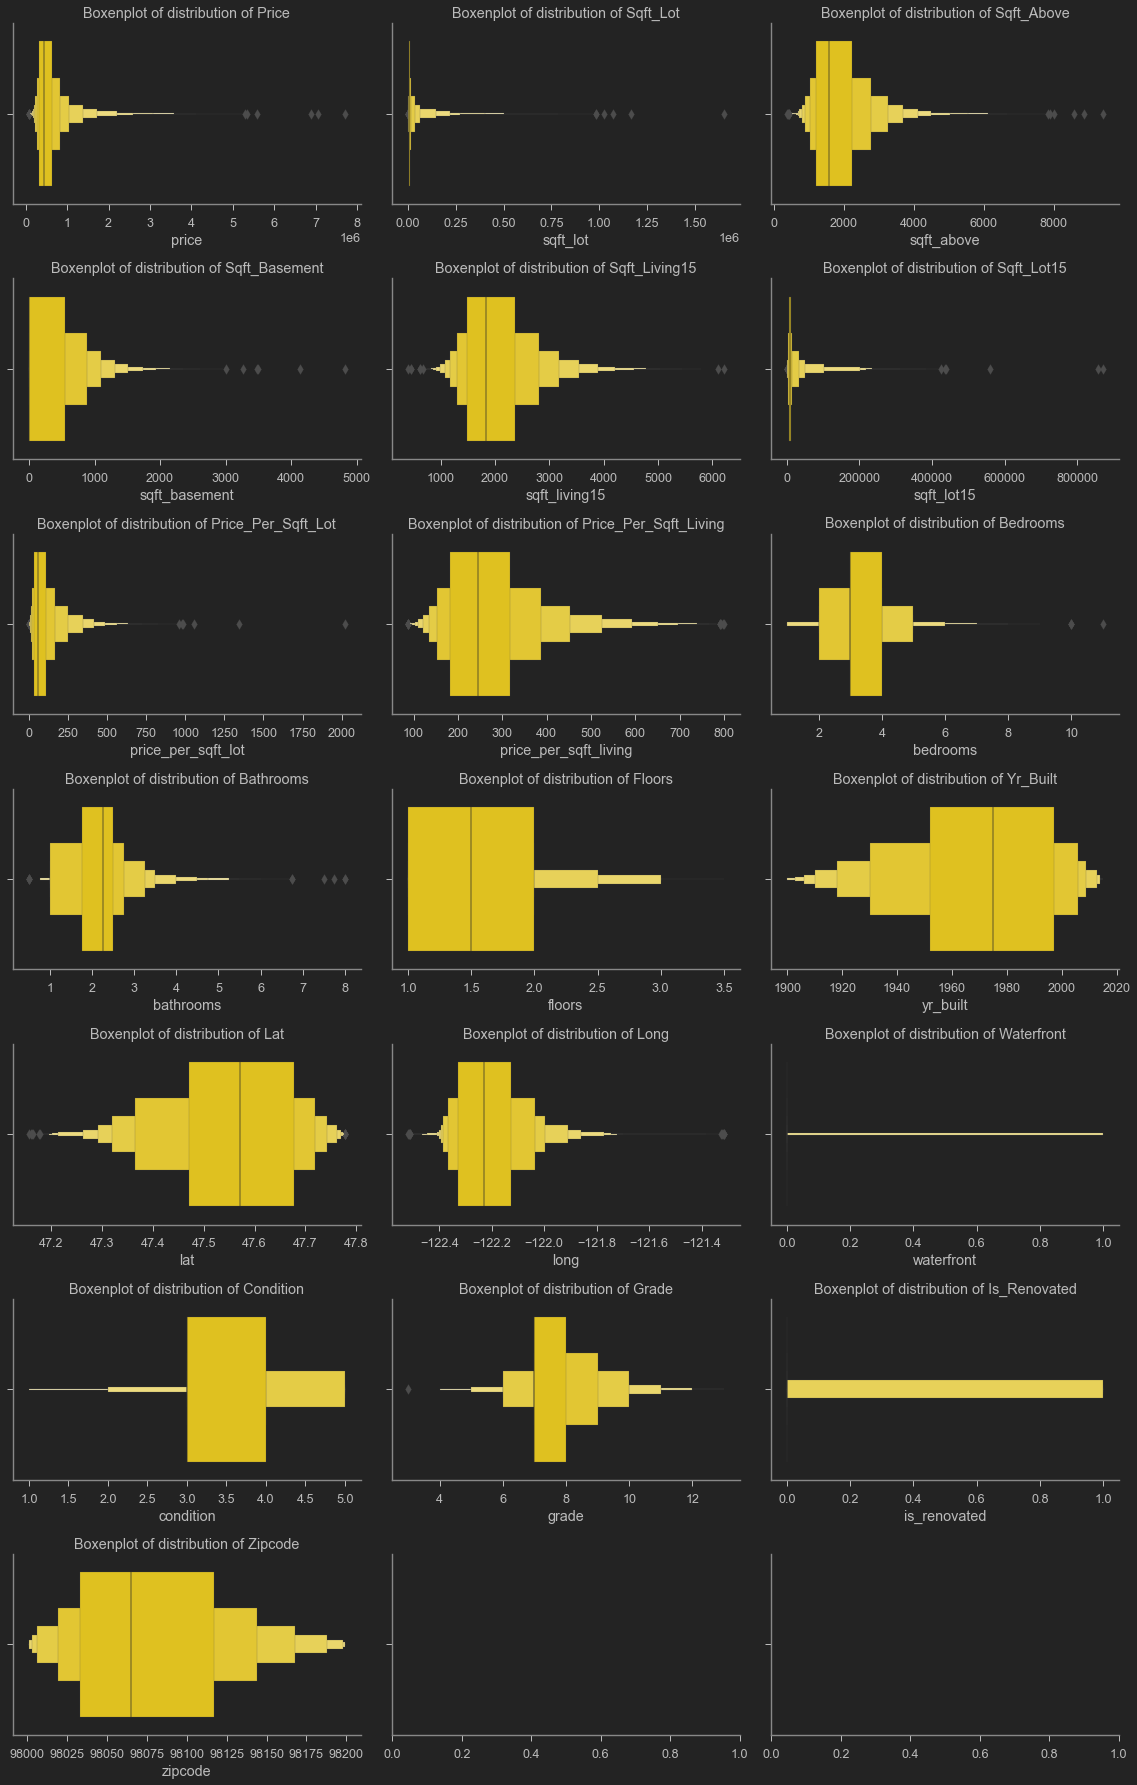

In [87]:
check_outliers_in_df(df_model,chart_type='boxenplot',turn_off_boxplot=False)

DataFrame Columns value counts.
____________________________________________________________
bedrooms: (11 unique values including NaN)
3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64
____________________________________________________________

____________________________________________________________
DataFrame Columns Boxenplot
____________________________________________________________


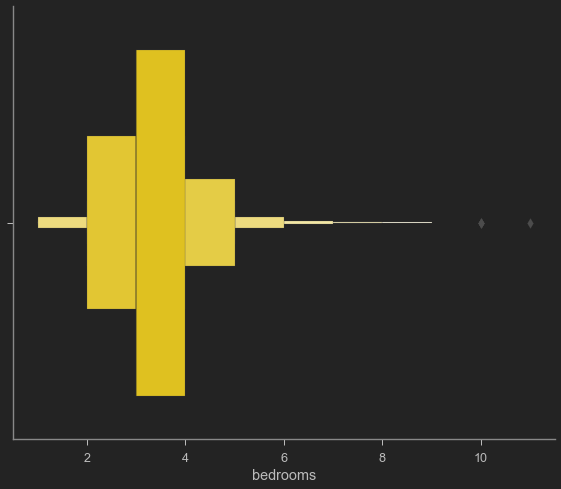

In [133]:
check_outliers_in_df(df_model[['bedrooms']],
                     chart_type='boxenplot',
                     turn_off_boxplot=False)

## Multiple Linear Regression

## Polynomial Regression

In [321]:
from sklearn.preprocessing import PolynomialFeatures

In [325]:
features1 = [
    'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
    'bedrooms', 'bathrooms', 'floors', 'yr_built', 'waterfront', 'condition',
    'grade', 'is_renovated', 'zipcode'
]

In [332]:
poly_feat = PolynomialFeatures(degree=2)
X_train_poly = poly_feat.fit_transform(df_model_train[features1])
X_test_poly = poly_feat.fit_transform(df_model_train[features1])

lin_reg_sk_poly = linear_model.LinearRegression()
lin_reg_sk_poly.fit(X_train_poly, df_model_train['price'])
y_pred_poly = lin_reg_sk_poly.predict(X_test_poly)

print('Poly Model_1 ^2')
mean_squared_error = metrics.mean_squared_error(df_model_train['price'],
                                                y_pred_poly)
print('Mean Squared Error (MSE) ', round(np.sqrt(mean_squared_error), 2))
print('R-squared (training) ',
      round(lin_reg_sk_poly.score(X_test_poly, df_model_train['price']), 3))
print('R-squared (testing) ',
      round(lin_reg_sk_poly.score(X_test_poly, df_model_train['price']), 3))

Poly Model_1 ^2
Mean Squared Error (MSE)  182115.41
R-squared (training)  0.758
R-squared (testing)  0.758


In [331]:
poly_feat = PolynomialFeatures(degree=3)
X_train_poly = poly_feat.fit_transform(df_model_train[features1])
X_test_poly = poly_feat.fit_transform(df_model_train[features1])

lin_reg_sk_poly = linear_model.LinearRegression()
lin_reg_sk_poly.fit(X_train_poly, df_model_train['price'])
y_pred_poly = lin_reg_sk_poly.predict(X_test_poly)

print('Poly Model_2 ^3')
mean_squared_error = metrics.mean_squared_error(df_model_train['price'],
                                                y_pred_poly)
print('Mean Squared Error (MSE) ', round(np.sqrt(mean_squared_error), 2))
print('R-squared (training) ',
      round(lin_reg_sk_poly.score(X_test_poly, df_model_train['price']), 3))
print('R-squared (testing) ',
      round(lin_reg_sk_poly.score(X_test_poly, df_model_train['price']), 3))

Poly Model_2 ^3
Mean Squared Error (MSE)  197950.82
R-squared (training)  0.714
R-squared (testing)  0.714


# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS